#  <span style="color:#3366ff"> <strong> Segmenter le comportement de clients (Arnaud ROUSSEAU) </strong>

# <span style="color:#3366ff"> 2018 July 10th (Part 2: Machine Learning)

<span style="color:#3366ff"> This notebook is dedicated to the data engineering 

### Libraries Import

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn import cluster , svm, model_selection, preprocessing, metrics, kernel_ridge, neighbors
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score 
from sklearn.feature_selection import SelectFromModel

from collections import Counter

import datetime as dt

### Databases loading

In [2]:
data_client_full= pd.read_csv(
    'DATA_clean/data_Client.csv', 
    #sep='\t', 
    index_col=0,
    encoding='utf-8', 
    low_memory = False)

shape = data_client_full.shape

print("Cette base de données contient",shape[0], 
      "achats décrits avec", shape[1], "paramètres.")

Cette base de données contient 397630 achats décrits avec 5 paramètres.


In [3]:
data_client_full.head()

,InvoiceNo,CustomerID,Quantity,InvoiceDate,UnitPrice
0,536365,17850.0,6,2010-12-01 08:26:00,2.55
1,536365,17850.0,6,2010-12-01 08:26:00,3.39
2,536365,17850.0,8,2010-12-01 08:26:00,2.75
3,536365,17850.0,6,2010-12-01 08:26:00,3.39
4,536365,17850.0,6,2010-12-01 08:26:00,3.39


In [4]:
IDcount = data_client_full['CustomerID'].unique()

print("There are",IDcount.shape[0],"different customers in this database.")

There are 4334 different customers in this database.


### New Column: Total Price

In [5]:
data_client_full['TotalPrice'] = data_client_full['Quantity'] * data_client_full['UnitPrice']
data_client_full['TotalPrice'].head()

0    15.30
1    20.34
2    22.00
3    20.34
4    20.34
Name: TotalPrice, dtype: float64

### Defining "NOW"

In [6]:
data_client_full['InvoiceDate'].min()

'2010-12-01 08:26:00'

In [7]:
data_client_full['InvoiceDate'].max()

'2011-12-09 12:50:00'

In [8]:
NOW = dt.datetime(2011,12,10)
data_client_full['InvoiceDate'] = pd.to_datetime(data_client_full['InvoiceDate'])
data_client_full['InvoiceDate'].head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

In [9]:
data_client = data_client_full
data_client['InvoiceDate2'] = data_client['InvoiceDate']
data_client['Quantity2'] = data_client['Quantity']
data_client.head()

,InvoiceNo,CustomerID,Quantity,InvoiceDate,UnitPrice,TotalPrice,InvoiceDate2,Quantity2
0,536365,17850.0,6,2010-12-01 08:26:00,2.55,15.30,2010-12-01 08:26:00,6
1,536365,17850.0,6,2010-12-01 08:26:00,3.39,20.34,2010-12-01 08:26:00,6
2,536365,17850.0,8,2010-12-01 08:26:00,2.75,22.00,2010-12-01 08:26:00,8
3,536365,17850.0,6,2010-12-01 08:26:00,3.39,20.34,2010-12-01 08:26:00,6
4,536365,17850.0,6,2010-12-01 08:26:00,3.39,20.34,2010-12-01 08:26:00,6


In [10]:
shape = data_client.shape

print("Cette base de données contient",shape[0], 
      "achats décrits avec", shape[1], "paramètres.")

Cette base de données contient 397630 achats décrits avec 8 paramètres.


# Customers Profiling with RFM Score 

<strong> RFM Score : RECENCY / FREQUENCY / MONETARY VALUE

RFM table

In [11]:
rfmTable = data_client.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, 
                                          'InvoiceNo': lambda x: len(x.unique()), 
                                          'TotalPrice': lambda x: x.sum(), 
                                          'UnitPrice': lambda x: x.mean(),
                                          'Quantity': lambda x: x.sum(),
                                          'Quantity2': lambda x: x.mean(),       
                                          'InvoiceDate2': lambda x: ( ( x.diff() )/len(x) ).mean()
                                           })

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)

rfmTable.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'TotalPrice': 'Monetary_value',
                         'UnitPrice': 'Mean_Price_pTransaction',
                         'Quantity': 'Total_Quant',
                         'Quantity2': 'Mean_Quant_pTransaction',
                         'InvoiceDate2': 'Mean_Tim_Betwn_2_Purchas' 
                        }, 
                         inplace=True)

rfmTable.head(10)

,Recency,Frequency,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,Mean_Tim_Betwn_2_Purchas
CustomerID,,,,,,,
12347.0,2,7,4310.00,2.644011,2458,13.505495,00:15:57.419100
12348.0,75,4,1797.24,5.764839,2341,75.516129,07:17:48.645161
12349.0,18,1,1757.55,8.289041,631,8.643836,00:00:00
12350.0,310,1,334.40,3.841176,197,11.588235,00:00:00
12352.0,36,7,1665.74,6.265976,533,6.500000,00:56:23.233965
12353.0,204,1,89.00,6.075000,20,5.000000,00:00:00
12354.0,232,1,1079.40,4.503793,530,9.137931,00:00:00
12355.0,214,1,459.40,4.203846,240,18.461538,00:00:00
12356.0,22,3,2811.43,3.201186,1591,26.966102,02:07:29.035651


In [12]:
rfmTable['Mean_Tim_Betwn_2_Purchas'].describe()

count                      4265
mean     0 days 09:05:39.665013
std      4 days 01:41:37.391669
min             0 days 00:00:00
25%             0 days 00:00:00
50%      0 days 00:11:33.449127
75%      0 days 01:12:19.879616
max           154 days 15:20:00
Name: Mean_Tim_Betwn_2_Purchas, dtype: object

In [13]:
rfmTable['Quant_Mean_Year'] = rfmTable['Total_Quant'] / rfmTable['Frequency']
rfmTable['Quant_Mean_Month'] = rfmTable['Quant_Mean_Year']  / 12

rfmTable['Quant_Mean_Year'] = rfmTable['Quant_Mean_Year'].astype(int)
rfmTable['Quant_Mean_Month'] = rfmTable['Quant_Mean_Month'].astype(int)

rfmTable.head()

,Recency,Frequency,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,Mean_Tim_Betwn_2_Purchas,Quant_Mean_Year,Quant_Mean_Month
CustomerID,,,,,,,,,
12347.0,2,7,4310.00,2.644011,2458,13.505495,00:15:57.419100,351,29
12348.0,75,4,1797.24,5.764839,2341,75.516129,07:17:48.645161,585,48
12349.0,18,1,1757.55,8.289041,631,8.643836,00:00:00,631,52
12350.0,310,1,334.40,3.841176,197,11.588235,00:00:00,197,16
12352.0,36,7,1665.74,6.265976,533,6.500000,00:56:23.233965,76,6


Split the metrics

In [14]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [15]:
segmented_rfm = rfmTable

The lowest recency, highest frequency and monetary amounts are best customers.

In [16]:
# Recency score
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [17]:
# Frequency and Monetary Score    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [18]:
segmented_rfm['r_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['Monetary_value'].apply(FMScore, args=('Monetary_value',quantiles,))

segmented_rfm.head()

,Recency,Frequency,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,Mean_Tim_Betwn_2_Purchas,Quant_Mean_Year,Quant_Mean_Month,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,,,,,,,
12347.0,2,7,4310.00,2.644011,2458,13.505495,00:15:57.419100,351,29,1,1,1
12348.0,75,4,1797.24,5.764839,2341,75.516129,07:17:48.645161,585,48,3,2,1
12349.0,18,1,1757.55,8.289041,631,8.643836,00:00:00,631,52,2,4,1
12350.0,310,1,334.40,3.841176,197,11.588235,00:00:00,197,16,4,4,3
12352.0,36,7,1665.74,6.265976,533,6.500000,00:56:23.233965,76,6,2,1,1


In [19]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) \
                            + segmented_rfm.f_quartile.map(str) \
                            + segmented_rfm.m_quartile.map(str)

segmented_rfm.head()

,Recency,Frequency,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,Mean_Tim_Betwn_2_Purchas,Quant_Mean_Year,Quant_Mean_Month,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,,,,,,
12347.0,2,7,4310.00,2.644011,2458,13.505495,00:15:57.419100,351,29,1,1,1,111
12348.0,75,4,1797.24,5.764839,2341,75.516129,07:17:48.645161,585,48,3,2,1,321
12349.0,18,1,1757.55,8.289041,631,8.643836,00:00:00,631,52,2,4,1,241
12350.0,310,1,334.40,3.841176,197,11.588235,00:00:00,197,16,4,4,3,443
12352.0,36,7,1665.74,6.265976,533,6.500000,00:56:23.233965,76,6,2,1,1,211


In [20]:
segmented_rfm = segmented_rfm.filter(items=(['Recency',
                                             'Frequency', 
                                             'Mean_Tim_Betwn_2_Purchas',
                                             'Monetary_value', 
                                             'Mean_Price_pTransaction',
                                             'Total_Quant',
                                             'Mean_Quant_pTransaction',
                                             #'Quant_Mean_Year',                                              
                                             #'Quant_Mean_Month', 
                                             'RFMScore']))
segmented_rfm.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore
CustomerID,,,,,,,,
12347.0,2,7,00:15:57.419100,4310.00,2.644011,2458,13.505495,111
12348.0,75,4,07:17:48.645161,1797.24,5.764839,2341,75.516129,321
12349.0,18,1,00:00:00,1757.55,8.289041,631,8.643836,241
12350.0,310,1,00:00:00,334.40,3.841176,197,11.588235,443
12352.0,36,7,00:56:23.233965,1665.74,6.265976,533,6.500000,211


In [21]:
rfm_unique = segmented_rfm['RFMScore'].unique()
rfm_unique

array(['111', '321', '241', '443', '211', '444', '442', '221', '132',
       '333', '122', '144', '231', '322', '242', '133', '432', '341',
       '332', '121', '421', '233', '433', '343', '243', '441', '423',
       '431', '342', '222', '244', '331', '131', '434', '311', '232',
       '112', '142', '143', '334', '223', '234', '323', '212', '344',
       '123', '412', '134', '411', '324', '224', '124', '422', '312',
       '424', '413', '141', '113', '114', '313', '414'], dtype=object)

In [22]:
shaperfm_unique = rfm_unique.shape

print("There are",shaperfm_unique[0], "customers profiles :/ !")

There are 61 customers profiles :/ !


<strong> Top 10 of the best customers:

<span style="color:#3366ff"> "111" are customers who buy a lot of things, frequently & recently.

In [23]:
seg111 = segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('Monetary_value', ascending=False).head()
seg111

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore
CustomerID,,,,,,,,
14646.0,1,74,00:00:07.054653,280206.02,2.488505,197491,94.947596,111
18102.0,0,60,00:02:50.999190,259657.30,4.503295,64124,148.779582,111
17450.0,8,46,00:04:34.059983,194550.79,3.392641,69993,207.694362,111
14911.0,1,199,00:00:00.998366,140450.72,4.019626,80513,14.187313,111
14156.0,9,55,00:00:15.967303,117379.63,3.826914,57885,41.346429,111


In [24]:
seg111.shape

(5, 8)

# Selection of Interesting / Most Frequent Profiles

In [25]:
dic = {}
li = []
uniq = segmented_rfm['RFMScore'].unique()

for i in uniq:
    dic = {}
    dic["RFM Profile"] = i
    uuu = segmented_rfm[segmented_rfm['RFMScore']== i]
    shauuu = uuu.shape
    dic["Nb of customers"] = shauuu[0]
    li.append(dic)  

In [26]:
RFM_list = pd.DataFrame(li)
RFM_list = RFM_list.sort_values('Nb of customers', ascending=False)
RFM_list = RFM_list.set_index('RFM Profile')

In [27]:
IDcount = sum(RFM_list['Nb of customers'])
RFM_list['% Customers'] = RFM_list['Nb of customers'] / IDcount * 100
RFM_list.head(15)

,Nb of customers,% Customers
RFM Profile,,
111,458,10.567605
444,445,10.267651
443,221,5.099216
344,210,4.845408
222,189,4.360868
211,186,4.291647
122,174,4.014767
322,163,3.760960
244,146,3.368713


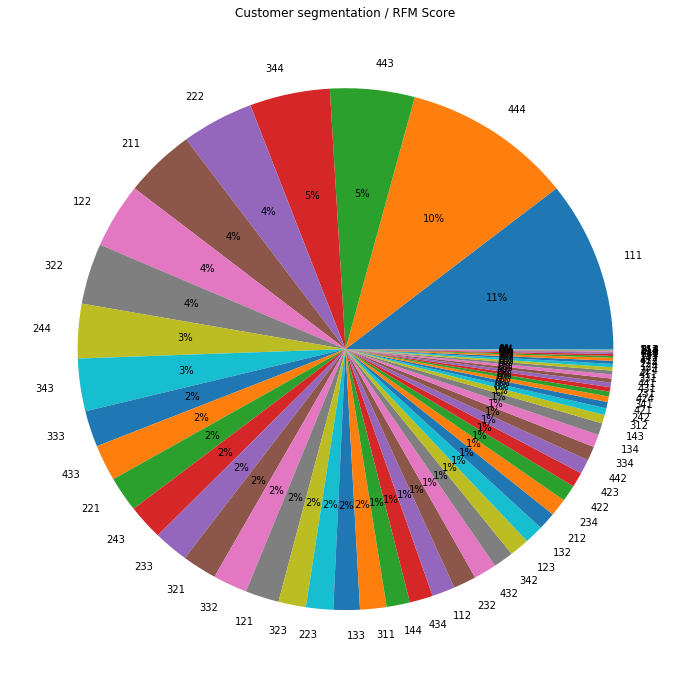

In [28]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot()
ax.set_title("Customer segmentation / RFM Score")

plt.pie(RFM_list['Nb of customers'], 
        explode=None, 
        labels=RFM_list.index, 
        colors=None, 
        autopct='%.0f%%', 
        pctdistance=0.6, 
        shadow=False, 
        labeldistance=1.1, 
        startangle=None, 
        radius=None, 
        counterclock=True, 
        wedgeprops=None, 
        textprops=None, 
        center=(0, 0), 
        frame=False, 
        rotatelabels=False, 
        hold=None, 
        data=None 
       )
plt.show()

<span style="color:#3366ff"> The first 10 are interresting (present more than 3%).

In [29]:
RFM_list_OK = RFM_list['% Customers'] > 3
RFM_list_OK = RFM_list_OK[RFM_list_OK == True]
RFM_list_OK.index.get_level_values(0)

Index(['111', '444', '443', '344', '222', '211', '122', '322', '244', '343'], dtype='object', name='RFM Profile')

In [30]:
segmented_rfm = segmented_rfm[segmented_rfm['RFMScore'].isin(RFM_list_OK.index.get_level_values(0))]
segmented_rfm.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore
CustomerID,,,,,,,,
12347.0,2,7,00:15:57.419100,4310.00,2.644011,2458,13.505495,111
12350.0,310,1,00:00:00,334.40,3.841176,197,11.588235,443
12352.0,36,7,00:56:23.233965,1665.74,6.265976,533,6.500000,211
12353.0,204,1,00:00:00,89.00,6.075000,20,5.000000,444
12355.0,214,1,00:00:00,459.40,4.203846,240,18.461538,443


In [31]:
segmented_rfm.shape

(2333, 8)

# RFM Code Conversion

In [32]:
# Score RFM / Value association
def ScoreConv(x):
    if x == '111':
        return int(1)
    elif x == '444':
        return int(2)
    elif x == '443': 
        return int(3)
    elif x == '344': 
        return int(4)
    elif x == '222': 
        return int(5)
    elif x == '211': 
        return int(6)
    elif x == '122': 
        return int(7)
    elif x == '322': 
        return int(8)
    elif x == '244': 
        return int(9)
    elif x == '343': 
        return int(10)

In [33]:
segmented_rfm['RFM_Cat'] = segmented_rfm['RFMScore'].apply(lambda x: ScoreConv(x))
segmented_rfm['RFM_Cat'] = segmented_rfm['RFM_Cat'].astype(int)

In [34]:
segmented_rfm.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
12347.0,2,7,00:15:57.419100,4310.00,2.644011,2458,13.505495,111,1
12350.0,310,1,00:00:00,334.40,3.841176,197,11.588235,443,3
12352.0,36,7,00:56:23.233965,1665.74,6.265976,533,6.500000,211,6
12353.0,204,1,00:00:00,89.00,6.075000,20,5.000000,444,2
12355.0,214,1,00:00:00,459.40,4.203846,240,18.461538,443,3


#  <span style="color:#ff0000"> Segment Description

<strong> Cat 1 / 111 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

In [35]:
seg111 = segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('Monetary_value', ascending=False)
seg111.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
14646.0,1,74,00:00:07.054653,280206.02,2.488505,197491,94.947596,111,1
18102.0,0,60,00:02:50.999190,259657.30,4.503295,64124,148.779582,111,1
17450.0,8,46,00:04:34.059983,194550.79,3.392641,69993,207.694362,111,1
14911.0,1,199,00:00:00.998366,140450.72,4.019626,80513,14.187313,111,1
14156.0,9,55,00:00:15.967303,117379.63,3.826914,57885,41.346429,111,1


In [36]:
min(seg111['Monetary_value'])

1659.3799999999999

In [37]:
min(seg111['Frequency'])

6

In [38]:
max(seg111['Frequency'])

206

In [39]:
min(seg111['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 00:00:00.321783')

In [40]:
max(seg111['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 21:48:15')

In [41]:
min(seg111['Total_Quant'])

416

In [42]:
max(seg111['Total_Quant'])

197491

In [43]:
min(seg111['Mean_Price_pTransaction'])

0.6638219895287966

In [44]:
max(seg111['Mean_Price_pTransaction'])

11.084864864864864

In [45]:
seg111['Mean_Price_pTransaction'].mean()

3.0026398705973465

In [46]:
min(seg111['Mean_Quant_pTransaction'])

1.7832861189801699

In [47]:
max(seg111['Mean_Quant_pTransaction'])

715.2

In [48]:
seg111['Mean_Quant_pTransaction'].mean()

22.911821190606915

In [49]:
seg111_f = segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('Frequency', ascending=False)
seg111_f.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
12748.0,0,206,00:00:01.535939,32321.32,2.375951,25512,5.569090,111,1
14911.0,1,199,00:00:00.998366,140450.72,4.019626,80513,14.187313,111,1
17841.0,1,124,00:00:00.523090,40967.72,2.530529,23053,2.941184,111,1
13089.0,2,97,00:00:09.597566,58825.83,2.737816,31070,17.090209,111,1
14606.0,1,92,00:00:04.415036,12141.65,2.808725,6223,2.305669,111,1


In [50]:
seg111_r = segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('Frequency', ascending=False)
seg111_r.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
12748.0,0,206,00:00:01.535939,32321.32,2.375951,25512,5.569090,111,1
14911.0,1,199,00:00:00.998366,140450.72,4.019626,80513,14.187313,111,1
17841.0,1,124,00:00:00.523090,40967.72,2.530529,23053,2.941184,111,1
13089.0,2,97,00:00:09.597566,58825.83,2.737816,31070,17.090209,111,1
14606.0,1,92,00:00:04.415036,12141.65,2.808725,6223,2.305669,111,1


In [51]:
max(seg111['Recency'])

17

In [52]:
min(seg111['Recency'])

0

<span style="color:#3366ff"> This is the "Loyal" category: a lot of things, frequently & recently (between 0 and 17 days).

<strong> Cat 2 / 444 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

In [53]:
seg444 = segmented_rfm[segmented_rfm['RFMScore']=='444'].sort_values('Monetary_value', ascending=False)
seg444.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
15087.0,281,1,0 days,306.94,2.036000,470,31.333333,444,2
17551.0,359,1,0 days,306.84,2.541163,150,3.488372,444,2
13762.0,218,1,0 days,306.72,1.260000,272,38.857143,444,2
17176.0,201,1,0 days,306.13,2.772667,170,11.333333,444,2
13863.0,247,1,0 days,305.78,2.596500,224,11.200000,444,2


In [54]:
seg444.shape

(445, 9)

In [55]:
min(seg444['Monetary_value'])

2.9

In [56]:
max(seg444['Monetary_value'])

306.94

In [57]:
min(seg444['Recency'])

143

In [58]:
max(seg444['Recency'])

373

In [59]:
min(seg444['Frequency'])

1

In [60]:
max(seg444['Frequency'])

1

In [61]:
min(seg444['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 00:00:00')

In [62]:
max(seg444['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 00:00:00')

In [63]:
min(seg444['Total_Quant'])

1

In [64]:
max(seg444['Total_Quant'])

924

In [65]:
min(seg444['Mean_Price_pTransaction'])

0.39375000000000004

In [66]:
max(seg444['Mean_Price_pTransaction'])

125.0

In [67]:
seg444['Mean_Price_pTransaction'].mean()

4.326180891434795

In [68]:
min(seg444['Mean_Quant_pTransaction'])

1.0

In [69]:
max(seg444['Mean_Quant_pTransaction'])

192.0

In [70]:
seg444['Mean_Quant_pTransaction'].mean()

12.287406998308295

<span style="color:#3366ff"> This is the "prospect" category: 

<strong> Cat 3 / 443 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

In [71]:
seg443 = segmented_rfm[segmented_rfm['RFMScore']=='443'].sort_values('Monetary_value', ascending=False)
seg443.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
14603.0,274,1,0 days,660.00,1.650000,400,200.000000,443,3
17046.0,157,1,0 days,642.02,2.169091,510,23.181818,443,3
14000.0,211,1,0 days,635.66,1.949333,710,47.333333,443,3
16022.0,260,1,0 days,628.28,3.308947,261,3.434211,443,3
14036.0,284,1,0 days,626.65,4.371842,268,7.052632,443,3


In [72]:
min(seg443['Monetary_value'])

307.4

In [73]:
max(seg443['Recency'])

373

In [74]:
min(seg443['Recency'])

145

In [75]:
max(seg443['Frequency'])

1

In [76]:
min(seg443['Frequency'])

1

In [77]:
min(seg443['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 00:00:00')

In [78]:
max(seg443['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 00:00:00.118577')

In [79]:
min(seg443['Total_Quant'])

4

In [80]:
max(seg443['Total_Quant'])

711

In [81]:
min(seg443['Mean_Price_pTransaction'])

0.85

In [82]:
max(seg443['Mean_Price_pTransaction'])

110.0

In [83]:
seg443['Mean_Price_pTransaction'].mean()

4.439064022318309

In [84]:
min(seg443['Mean_Quant_pTransaction'])

1.4782608695652173

In [85]:
max(seg443['Mean_Quant_pTransaction'])

504.0

In [86]:
seg443['Mean_Quant_pTransaction'].mean()

19.68964255013034

<span style="color:#3366ff"> This is a "prospect" category too: 

<strong> Cat 4 / 344 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

In [87]:
seg344 = segmented_rfm[segmented_rfm['RFMScore']=='344'].sort_values('Monetary_value', ascending=False)
seg344.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
16796.0,89,1,0 days,305.62,1.745556,186,10.333333,344,4
16181.0,73,1,0 days,305.54,2.411818,152,13.818182,344,4
13045.0,99,1,0 days,305.28,1.570556,221,12.277778,344,4
17941.0,130,1,0 days,304.56,1.255000,252,126.000000,344,4
16400.0,94,1,0 days,303.93,3.014138,172,5.931034,344,4


In [88]:
seg344_r = segmented_rfm[segmented_rfm['RFMScore']=='344'].sort_values('Recency', ascending=False)
seg344_r.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
17962.0,142,1,0 days,102.83,1.651714,128,3.657143,344,4
15623.0,141,1,0 days,301.03,4.290526,125,6.578947,344,4
17694.0,141,1,0 days,283.12,2.608667,184,12.266667,344,4
17660.0,141,1,0 days,196.00,2.003778,130,2.888889,344,4
14259.0,141,1,0 days,120.00,2.830000,68,13.600000,344,4


In [89]:
min(seg344['Monetary_value'])

5.9

In [90]:
min(seg344['Recency'])

51

In [91]:
max(seg344['Recency'])

142

In [92]:
max(seg344['Frequency'])

1

In [93]:
min(seg344['Frequency'])

1

In [94]:
min(seg344['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 00:00:00')

In [95]:
max(seg344['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 00:00:00')

In [96]:
max(seg344['Total_Quant'])

1440

In [97]:
min(seg344['Total_Quant'])

2

In [98]:
min(seg344['Mean_Price_pTransaction'])

0.17

In [99]:
max(seg344['Mean_Price_pTransaction'])

22.962500000000002

In [100]:
seg344['Mean_Price_pTransaction'].mean()

3.208176774159636

In [101]:
min(seg344['Mean_Quant_pTransaction'])

1.0

In [102]:
max(seg344['Mean_Quant_pTransaction'])

1440.0

In [103]:
seg344['Mean_Quant_pTransaction'].mean()

20.912927196411015

<span style="color:#3366ff"> This is a "prospect" category too:

<strong> Cat 5 / 222

In [104]:
seg222 = segmented_rfm[segmented_rfm['RFMScore']=='222'].sort_values('Monetary_value', ascending=False)
seg222.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
13614.0,24,4,00:10:57.865671,1610.46,3.774876,570,2.835821,222,5
16676.0,33,4,00:55:53.174157,1592.12,4.986742,636,7.146067,222,5
13186.0,39,3,00:20:49.376825,1575.89,3.248608,820,10.379747,222,5
13634.0,33,5,00:12:02.351803,1575.16,3.330585,704,3.744681,222,5
15532.0,25,4,00:07:24.100046,1571.03,3.873961,519,2.035294,222,5


In [105]:
seg222_f = segmented_rfm[segmented_rfm['RFMScore']=='222'].sort_values('Frequency', ascending=False)
seg222_f.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
14748.0,29,5,01:02:23.518896,1415.75,1.860225,1223,13.741573,222,5
13636.0,36,5,01:31:44.162826,949.12,3.785397,592,9.396825,222,5
14214.0,30,5,01:20:24.491180,1004.38,2.340746,751,11.208955,222,5
15426.0,19,5,00:05:55.953255,1447.39,2.687774,674,2.308219,222,5
16907.0,29,5,00:21:21.886092,981.65,3.786623,298,1.973510,222,5


In [106]:
seg222_r = segmented_rfm[segmented_rfm['RFMScore']=='222'].sort_values('Recency', ascending=False)
seg222_r.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
15587.0,50,4,4 days 04:23:01.666666,913.68,2.916667,312,34.666667,222,5
17571.0,50,4,0 days 00:04:02.127313,1497.26,2.763289,904,3.033557,222,5
15807.0,50,3,0 days 00:17:13.164893,903.90,2.581250,430,8.958333,222,5
16099.0,50,3,0 days 02:50:13.724696,731.90,1.868462,434,11.128205,222,5
14631.0,50,3,0 days 03:37:49.243902,1006.98,2.383902,622,15.170732,222,5


In [107]:
min(seg222['Monetary_value'])

673.26

In [108]:
max(seg222['Recency'])

50

In [109]:
min(seg222['Recency'])

18

In [110]:
max(seg222['Frequency'])

5

In [111]:
min(seg222['Frequency'])

3

In [112]:
min(seg222['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 00:00:12.948891')

In [113]:
max(seg222['Mean_Tim_Betwn_2_Purchas'])

Timedelta('4 days 04:23:01.666666')

In [114]:
min(seg222['Total_Quant'])

134

In [115]:
max(seg222['Total_Quant'])

2571

In [116]:
min(seg222['Mean_Price_pTransaction'])

0.9595081967213114

In [117]:
max(seg222['Mean_Price_pTransaction'])

7.388

In [118]:
seg222['Mean_Price_pTransaction'].mean()

3.008788943629564

In [119]:
min(seg222['Mean_Quant_pTransaction'])

1.9735099337748345

In [120]:
max(seg222['Mean_Quant_pTransaction'])

72.0

In [121]:
seg222['Mean_Quant_pTransaction'].mean()

10.379991473828602

<span style="color:#3366ff"> This is 

<strong> Cat 6 / 211

In [122]:
seg211 = segmented_rfm[segmented_rfm['RFMScore']=='211'].sort_values('Monetary_value', ascending=False)
seg211.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
12415.0,24,21,00:00:52.847208,124914.53,2.928883,77670,108.477654,211,6
16029.0,38,62,00:08:20.446058,72882.09,2.405145,40207,166.834025,211,6
12931.0,21,15,01:12:52.303523,42055.96,1.701707,28004,341.512195,211,6
14680.0,25,16,00:07:31.121165,28754.11,2.415698,13476,52.232558,211,6
12753.0,22,6,00:12:40.718947,21429.39,2.337360,11421,57.974619,211,6


In [123]:
seg211_r = segmented_rfm[segmented_rfm['RFMScore']=='211'].sort_values('Recency', ascending=False)
seg211_r.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
15301.0,50,12,00:07:47.070707,5070.35,3.004609,2775,11.419753,211,6
15296.0,50,6,00:10:36.873030,3672.86,3.477629,1766,9.103093,211,6
15129.0,50,11,00:49:49.423407,3447.40,2.905238,1794,21.357143,211,6
16170.0,50,6,00:18:22.447741,1885.05,2.080320,1770,14.160000,211,6
17940.0,49,9,19:51:21.960784,2238.58,0.232778,9754,541.888889,211,6


In [124]:
min(seg211['Monetary_value'])

1665.7400000000002

In [125]:
max(seg211['Recency'])

50

In [126]:
min(seg211['Recency'])

18

In [127]:
max(seg211['Frequency'])

62

In [128]:
min(seg211['Frequency'])

6

In [129]:
min(seg211['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 00:00:20.497798')

In [130]:
max(seg211['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 19:51:21.960784')

In [131]:
min(seg211['Total_Quant'])

533

In [132]:
max(seg211['Total_Quant'])

77670

In [133]:
min(seg211['Mean_Price_pTransaction'])

0.2327777777777778

In [134]:
max(seg211['Mean_Price_pTransaction'])

6.698762886597939

In [135]:
seg211['Mean_Price_pTransaction'].mean()

3.0461813722340736

In [136]:
min(seg211['Mean_Quant_pTransaction'])

2.378812199036918

In [137]:
max(seg211['Mean_Quant_pTransaction'])

541.8888888888889

In [138]:
seg211['Mean_Quant_pTransaction'].mean()

22.993990534455527

<span style="color:#3366ff"> This is 

<strong> Cat 7 / 122

In [139]:
seg122 = segmented_rfm[segmented_rfm['RFMScore']=='122'].sort_values('Monetary_value', ascending=False)
seg122.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
16711.0,3,5,18:23:52.337662,1651.03,3.493182,833,37.863636,122,7
12657.0,11,4,00:44:44.375578,1643.18,5.044894,1044,22.212766,122,7
14759.0,4,3,00:31:52.568433,1625.97,5.394118,569,5.578431,122,7
15172.0,8,5,00:27:22.944120,1624.05,2.087909,1611,14.645455,122,7
17101.0,10,4,02:20:27.456445,1621.73,2.881190,815,19.404762,122,7


In [140]:
seg122_r = segmented_rfm[segmented_rfm['RFMScore']=='122'].sort_values('Recency', ascending=False)
seg122_r.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
17324.0,17,4,03:25:04.383673,990.23,2.765600,844,16.880000,122,7
17075.0,17,4,01:13:48.414217,834.12,3.846494,292,3.792208,122,7
13238.0,17,4,08:51:09.677419,700.73,4.110645,298,9.612903,122,7
17759.0,17,3,00:25:03.273850,833.74,2.277766,707,7.521277,122,7
13681.0,17,4,01:02:10.676691,827.83,2.902456,360,6.315789,122,7


In [141]:
min(seg122['Monetary_value'])

684.41

In [142]:
max(seg122['Frequency'])

5

In [143]:
min(seg122['Frequency'])

3

In [144]:
max(seg122['Recency'])

17

In [145]:
min(seg122['Recency'])

0

In [146]:
min(seg122['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 00:00:04.093754')

In [147]:
max(seg122['Mean_Tim_Betwn_2_Purchas'])

Timedelta('14 days 20:37:03')

In [148]:
min(seg122['Total_Quant'])

17

In [149]:
max(seg122['Total_Quant'])

2406

In [150]:
min(seg122['Mean_Price_pTransaction'])

0.6757500000000002

In [151]:
max(seg122['Mean_Price_pTransaction'])

54.3

In [152]:
seg122['Mean_Price_pTransaction'].mean()

3.308295070878653

In [153]:
min(seg122['Mean_Quant_pTransaction'])

1.3940886699507389

In [154]:
max(seg122['Mean_Quant_pTransaction'])

56.13333333333333

In [155]:
seg122['Mean_Quant_pTransaction'].mean()

11.546491339369968

<span style="color:#3366ff"> This is 

<strong> Cat 8 / 322

In [156]:
seg322 = segmented_rfm[segmented_rfm['RFMScore']=='322'].sort_values('Monetary_value', ascending=False)
seg322.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
15826.0,56,3,00:48:44.683933,1654.31,3.209412,963,14.161765,322,8
14837.0,89,4,00:13:56.806853,1649.50,1.757037,1436,13.296296,322,8
13750.0,53,5,12:18:18.586956,1647.26,5.020417,516,21.500000,322,8
15002.0,115,4,00:27:40.082379,1641.76,2.539478,862,7.495652,322,8
13627.0,59,5,00:51:17.314859,1638.47,2.974565,1269,13.793478,322,8


In [157]:
min(seg322['Monetary_value'])

678.25

In [158]:
max(seg322['Recency'])

142

In [159]:
min(seg322['Recency'])

51

In [160]:
max(seg322['Frequency'])

5

In [161]:
min(seg322['Frequency'])

3

In [162]:
min(seg322['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 00:00:00.827586')

In [163]:
max(seg322['Mean_Tim_Betwn_2_Purchas'])

Timedelta('13 days 16:41:24')

In [164]:
min(seg322['Total_Quant'])

196

In [165]:
max(seg322['Total_Quant'])

3700

In [166]:
min(seg322['Mean_Price_pTransaction'])

0.462

In [167]:
max(seg322['Mean_Price_pTransaction'])

21.259687500000005

In [168]:
seg322['Mean_Price_pTransaction'].mean()

3.166560279717423

In [169]:
min(seg322['Mean_Quant_pTransaction'])

2.7066666666666666

In [170]:
max(seg322['Mean_Quant_pTransaction'])

740.0

In [171]:
seg322['Mean_Quant_pTransaction'].mean()

19.084245866915385

<span style="color:#3366ff"> This is 

<strong> Cat 9 / 244

In [172]:
seg244 = segmented_rfm[segmented_rfm['RFMScore']=='244'].sort_values('Monetary_value', ascending=False)
seg244.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
15659.0,43,1,0 days,306.45,5.459091,111,10.090909,244,9
15667.0,39,1,0 days,301.32,1.555385,240,18.461538,244,9
15857.0,18,1,0 days,297.00,0.942857,308,22.000000,244,9
13449.0,23,1,0 days,291.88,1.924737,222,11.684211,244,9
16648.0,42,1,0 days,290.66,1.254211,281,14.789474,244,9


In [173]:
min(seg244['Monetary_value'])

20.8

In [174]:
max(seg244['Recency'])

50

In [175]:
min(seg244['Recency'])

18

In [176]:
max(seg244['Frequency'])

1

In [177]:
min(seg244['Frequency'])

1

In [178]:
max(seg244['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 00:00:00')

In [179]:
min(seg244['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 00:00:00')

In [180]:
max(seg244['Total_Quant'])

342

In [181]:
min(seg244['Total_Quant'])

10

In [182]:
min(seg244['Mean_Price_pTransaction'])

0.39

In [183]:
max(seg244['Mean_Price_pTransaction'])

9.58

In [184]:
seg244['Mean_Price_pTransaction'].mean()

2.6789770879482164

In [185]:
min(seg244['Mean_Quant_pTransaction'])

1.263157894736842

In [186]:
max(seg244['Mean_Quant_pTransaction'])

144.0

In [187]:
seg244['Mean_Quant_pTransaction'].mean()

11.670192232569477

<span style="color:#3366ff"> This is 

<strong> Cat 10 / 343

In [188]:
seg343 = segmented_rfm[segmented_rfm['RFMScore']=='343'].sort_values('Monetary_value', ascending=False)
seg343.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat
CustomerID,,,,,,,,,
12418.0,112,1,0 days,668.58,3.564412,407,11.970588,343,10
13518.0,85,1,0 days,659.44,2.751842,392,10.315789,343,10
14894.0,85,1,0 days,655.75,2.839565,265,11.521739,343,10
12631.0,57,1,0 days,640.50,4.537097,236,7.612903,343,10
14301.0,117,1,0 days,640.14,1.352308,606,46.615385,343,10


In [189]:
min(seg343['Monetary_value'])

307.78000000000003

In [190]:
max(seg343['Frequency'])

1

In [191]:
min(seg343['Frequency'])

1

In [192]:
max(seg343['Recency'])

142

In [193]:
min(seg343['Recency'])

51

In [194]:
max(seg343['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 00:00:00.100000')

In [195]:
min(seg343['Mean_Tim_Betwn_2_Purchas'])

Timedelta('0 days 00:00:00')

In [196]:
max(seg343['Total_Quant'])

1618

In [197]:
min(seg343['Total_Quant'])

43

In [198]:
min(seg343['Mean_Price_pTransaction'])

0.35800000000000004

In [199]:
max(seg343['Mean_Price_pTransaction'])

15.984285714285715

In [200]:
seg343['Mean_Price_pTransaction'].mean()

3.3518530029085265

In [201]:
min(seg343['Mean_Quant_pTransaction'])

2.078125

In [202]:
max(seg343['Mean_Quant_pTransaction'])

600.0

In [203]:
seg343['Mean_Quant_pTransaction'].mean()

22.768895182423424

<span style="color:#3366ff"> This is 

# Customers Client Synthesis

<span><table class="wikitable">
<tr>
<th>Segment Category</th>
<th>RFM Score</th>
<th>Description</th>
<th>Money Range in €</th>
<th>.</th>
<th>Mean_Quant_pTransaction</th>
<th>Mean_Price_pTransaction €</th>
</tr>
<tr>
<td>1</td>
<td>111</td>
<td>Loyal+: buy a lot, frequently & recently</td>
<td>1659 / 280206</td>
<td>.</td>
<td>22.9</td>
<td>3</td>
</tr>
<tr>
<td>2</td>
<td>444</td>
<td>Prospect</td>
<td>2.9 / 307</td>
<td>.</td>
<td>12.28</td>
<td>4.3</td>
</tr>
<tr>
<td>3</td>
<td>443</td>
<td>Good Prospect</td>
<td>307 / 660</td>
<td>.</td>
<td>19.68</td>
<td>4.43</td>
</tr>
<tr>
<td>4</td>
<td>344</td>
<td>Prospect</td>
<td>6 / 102</td>
<td>.</td>
<td>20.9</td>
<td>3.2</td>
</tr>
<tr>
<td>5</td>
<td>222</td>
<td>Rarely: between 3 & 5 times </td>
<td>673.26 / 1610.46</td>
<td>.</td>
<td>10.37</td>
<td>3</td>
</tr>
<tr>
<td>6</td>
<td>211</td>
<td>Rarely but A LOT</td>
<td>1665 / 124914</td>
<td>.</td>
<td>22.99</td>
<td>3.04</td>
</tr>
<tr>
<td>7</td> 
<td>122</td>
<td>Rarely: less than 5 times</td>
<td>684 / 1651</td>
<td>.</td>
<td>11.54</td>
<td>3.3</td>
</tr>
<tr>
<td>8</td>
<td>322</td>
<td>Loyal: between 51 & 142 times</td>
<td>678 / 1654</td>
<td>.</td>
<td>19.04</td>
<td>3.17</td>
</tr>
<tr>
<td>9</td>
<td>244</td>
<td>Prospect</td>
<td>20 / 306</td>
<td>.</td>
<td>11.67</td>
<td>2.67</td>
</tr>
<tr>
<td>10</td>
<td>343</td>
<td>Good Prospect</td>
<td>307 / 666.58</td>
<td>.</td>
<td>22.76</td>
<td>3.35</td>
</tr>
</table>

<span style="color:#3366ff"> Simplifcation based on the money range during a year:

<span><table class="wikitable">
<tr>
<th>Segment Category</th>
<th>RFM Score</th>
<th>Description</th>
<th>Money Range in €</th>
    
</tr>
<tr>
<td>1 & 6</td>
<td>x11</td>
<td>Hardcore Buyer: buy a lot</td>
<td>1659 / 280206</td>
</tr>
<tr>
<td>5,7,8</td>
<td>x22</td>
<td>Middle range Buyer</td>
<td>673 / 1654</td>
</tr>
<tr>
<td>2,3,4,9,10</td>
<td>x4x</td>
<td>Prospect</td>
<td>2.9 / 666.58</td>
</tr>
</table>

In [204]:
# Profile category / Value association
def ScoreConv2(x):
    if x == '111':
        return int(1)
    elif x == '444':
        return int(3)
    elif x == '443': 
        return int(3)
    elif x == '344': 
        return int(3)
    elif x == '222': 
        return int(2)
    elif x == '211': 
        return int(1)
    elif x == '122': 
        return int(2)
    elif x == '322': 
        return int(2)
    elif x == '244': 
        return int(3)
    elif x == '343': 
        return int(3)

In [205]:
segmented_rfm['Profile_Cat'] = segmented_rfm['RFMScore'].apply(lambda x: ScoreConv2(x))
segmented_rfm['Profile_Cat'] = segmented_rfm['Profile_Cat'].astype(int)
segmented_rfm.head()

,Recency,Frequency,Mean_Tim_Betwn_2_Purchas,Monetary_value,Mean_Price_pTransaction,Total_Quant,Mean_Quant_pTransaction,RFMScore,RFM_Cat,Profile_Cat
CustomerID,,,,,,,,,,
12347.0,2,7,00:15:57.419100,4310.00,2.644011,2458,13.505495,111,1,1
12350.0,310,1,00:00:00,334.40,3.841176,197,11.588235,443,3,3
12352.0,36,7,00:56:23.233965,1665.74,6.265976,533,6.500000,211,6,1
12353.0,204,1,00:00:00,89.00,6.075000,20,5.000000,444,2,3
12355.0,214,1,00:00:00,459.40,4.203846,240,18.461538,443,3,3


In [206]:
dic = {}
li = []
uniq = segmented_rfm['Profile_Cat'].unique()

for i in uniq:
    dic = {}
    dic["Profile"] = i
    uuu = segmented_rfm[segmented_rfm['Profile_Cat']== i]
    shauuu = uuu.shape
    dic["Nb of customers"] = shauuu[0]
    li.append(dic)  

In [207]:
Prof_cat_list = pd.DataFrame(li)
Prof_cat_list = Prof_cat_list.sort_values('Nb of customers', ascending=False)
Prof_cat_list = Prof_cat_list.set_index('Profile')

In [208]:
Cat_count = sum(Prof_cat_list['Nb of customers'])
Prof_cat_list['% Customers'] = Prof_cat_list['Nb of customers'] / Cat_count * 100
Prof_cat_list.head(15)

,Nb of customers,% Customers
Profile,,
3,1163,49.849979
1,644,27.603943
2,526,22.546078


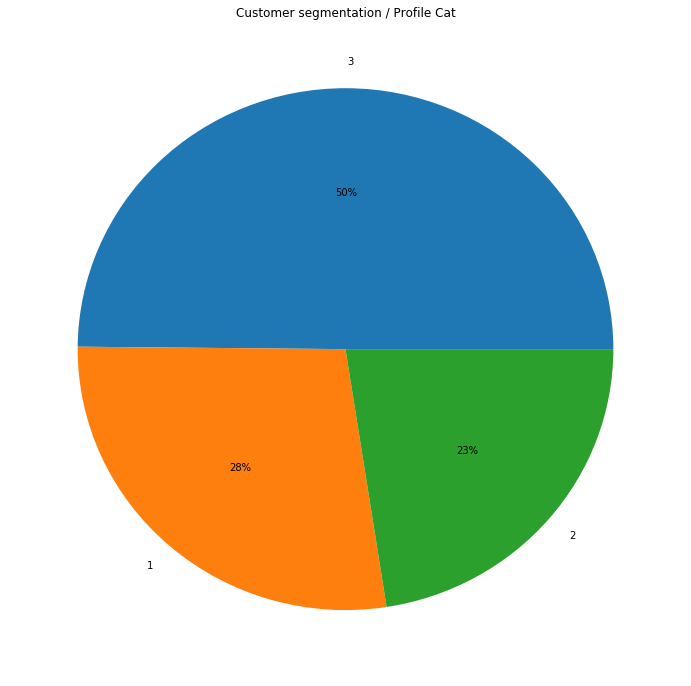

In [209]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot()
ax.set_title("Customer segmentation / Profile Cat")

plt.pie(Prof_cat_list['Nb of customers'], 
        explode=None, 
        labels=Prof_cat_list.index, 
        colors=None, 
        autopct='%.0f%%', 
        pctdistance=0.6, 
        shadow=False, 
        labeldistance=1.1, 
        startangle=None, 
        radius=None, 
        counterclock=True, 
        wedgeprops=None, 
        textprops=None, 
        center=(0, 0), 
        frame=False, 
        rotatelabels=False, 
        hold=None, 
        data=None 
       )
plt.show()

<strong> 1 = Hardcore Buyers / 2 = Middle Range Buyers / 3 = Prospects

<span style="color:#3366ff"> <Note:> This diagramm represents only the half of the Customers !

# Prepocessing 

<span style="color:#3366ff"> For the prediction, I'll use:    
    
<span style="color:#3366ff"> <strong>Base 1</strong>:     
<span style="color:#3366ff"> X = the 3 parameters 'Frequency', 'Recency', 'Monetary_value'      
<span style="color:#3366ff"> y = RFM Score      
<span style="color:#3366ff"> --> tested as a reference, will not be used because we won't have 'frequency', 'recency' for the prediction after the first purchase.      
    
<span style="color:#3366ff"> <strong>Base 2</strong>:     
<span style="color:#3366ff"> X2 = the 4 parameters 'Monetary_value', 'Mean_Price_pTransaction', 'Mean_Quant_pTransaction' & 'Total_Quant'.           
<span style="color:#3366ff"> y = RFM Score       
    
    
<span style="color:#3366ff"> <strong>Base 3</strong>:        
<span style="color:#3366ff"> X2 = the 4 parameters 'Monetary_value', 'Mean_Price_pTransaction', 'Mean_Quant_pTransaction' & 'Total_Quant'.                 
<span style="color:#3366ff"> y2 = Seg Cat    
    
<span style="color:#3366ff"> <strong>Base 4</strong>:    
<span style="color:#3366ff"> X3 = the 2 parameters 'Total_Quant', 'Monetary_value'    
<span style="color:#3366ff"> y2 = Seg Cat    

<strong> X 1 = 

In [210]:
data_client_rfm = segmented_rfm.filter(items=(['Frequency', 'Recency', 'Monetary_value']))
data_client_rfm.head()

,Frequency,Recency,Monetary_value
CustomerID,,,
12347.0,7,2,4310.00
12350.0,1,310,334.40
12352.0,7,36,1665.74
12353.0,1,204,89.00
12355.0,1,214,459.40


<strong> X 2 = 

In [211]:
data_client_rfm2 = segmented_rfm.filter(items=(['Total_Quant',
                                                'Mean_Quant_pTransaction', 
                                                'Mean_Price_pTransaction',
                                                'Monetary_value']))
data_client_rfm2.head()

,Total_Quant,Mean_Quant_pTransaction,Mean_Price_pTransaction,Monetary_value
CustomerID,,,,
12347.0,2458,13.505495,2.644011,4310.00
12350.0,197,11.588235,3.841176,334.40
12352.0,533,6.500000,6.265976,1665.74
12353.0,20,5.000000,6.075000,89.00
12355.0,240,18.461538,4.203846,459.40


<strong> X 3 = 

In [212]:
data_client_rfm3 = segmented_rfm.filter(items=(['Total_Quant',
                                                'Monetary_value']))
data_client_rfm3.head()

,Total_Quant,Monetary_value
CustomerID,,
12347.0,2458,4310.00
12350.0,197,334.40
12352.0,533,1665.74
12353.0,20,89.00
12355.0,240,459.40


# Y - - - - - - - - - - 

<strong> y1 = RFM Cat: 1,2,3,4,5,6,7,8,9,10

In [213]:
data_client_rfm_y = segmented_rfm.filter(items=(['RFM_Cat']))
data_client_rfm_y.head()

,RFM_Cat
CustomerID,
12347.0,1
12350.0,3
12352.0,6
12353.0,2
12355.0,3


<strong> y2 = Profile Cat 1,2,3

In [214]:
data_client_rfm_y2 = segmented_rfm.filter(items=(['Profile_Cat']))
data_client_rfm_y2.head()

,Profile_Cat
CustomerID,
12347.0,1
12350.0,3
12352.0,1
12353.0,3
12355.0,3


<strong> Ravel

In [215]:
data_rfm_rav_y = data_client_rfm_y['RFM_Cat'].ravel()
data_rfm_rav_y

array([1, 3, 6, ..., 2, 2, 1])

In [216]:
data_rfm_rav_y2 = data_client_rfm_y2['Profile_Cat'].ravel()
data_rfm_rav_y2

array([1, 3, 1, ..., 3, 3, 1])

# Y - - - - - - - - - - 

In [217]:
scaler_client = preprocessing.StandardScaler().fit(data_client_rfm)
X_scaled = scaler_client.transform(data_client_rfm) 

In [218]:
scaler_client2 = preprocessing.StandardScaler().fit(data_client_rfm2)
X_scaled2 = scaler_client2.transform(data_client_rfm2) 

In [219]:
scaler_client3 = preprocessing.StandardScaler().fit(data_client_rfm3)
X_scaled3 = scaler_client3.transform(data_client_rfm3) 

<strong> Base 1: 'Recency', 'Quantity', 'Monetary_value' --> RFM Score

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, data_rfm_rav_y, test_size = 0.3)

<strong> Base 2: 'Total_Quant', 'Mean_Quant_pTransaction', 'Mean_Price_pTransaction', 'Monetary_value' --> RFM Score

In [221]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled2, data_rfm_rav_y, test_size = 0.3)

<strong> Base 3: 'Total_Quant', 'Mean_Quant_pTransaction', 'Mean_Price_pTransaction', 'Monetary_value' --> Profile Category 1, 2, 3

In [222]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_scaled2, data_rfm_rav_y2, test_size = 0.3)

<strong> Base 4: 'Total_Quant','Monetary_value' --> Profile Category 1, 2, 3

In [223]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_scaled3, data_rfm_rav_y2, test_size = 0.3)

# ML CLASSIFICATION:  kNN

### kNN with Base 1: ( Quantity, Recency, Monetary_value)  --> RFMScore

<strong> Add column of 1

In [224]:
xones = np.ones(X_train.shape[0])
xones = pd.DataFrame(xones)
xtrain = pd.DataFrame(X_train)
xtrain = pd.concat([xones, xtrain], axis = 1)
xtrain.head()

,0,0,1,2
0,1.0,-0.429647,0.613428,-0.191005
1,1.0,-0.429647,-0.694172,-0.225404
2,1.0,-0.429647,1.369524,-0.181392
3,1.0,-0.429647,1.974400,-0.225326
4,1.0,-0.429647,1.520743,-0.215140


In [225]:
xones = np.ones(X_test.shape[0])
xones = pd.DataFrame(xones)
xtest = pd.DataFrame(X_test)
xtest = pd.concat([xones, xtest], axis = 1)
xtest.head()

,0,0,1,2
0,1.0,-0.429647,1.716438,-0.202922
1,1.0,0.164172,-0.836496,0.213522
2,1.0,0.263142,-0.765334,0.281621
3,1.0,-0.429647,0.079714,-0.176266
4,1.0,-0.429647,1.903238,-0.220992


In [226]:
ytrain = y_train
ytest = y_test

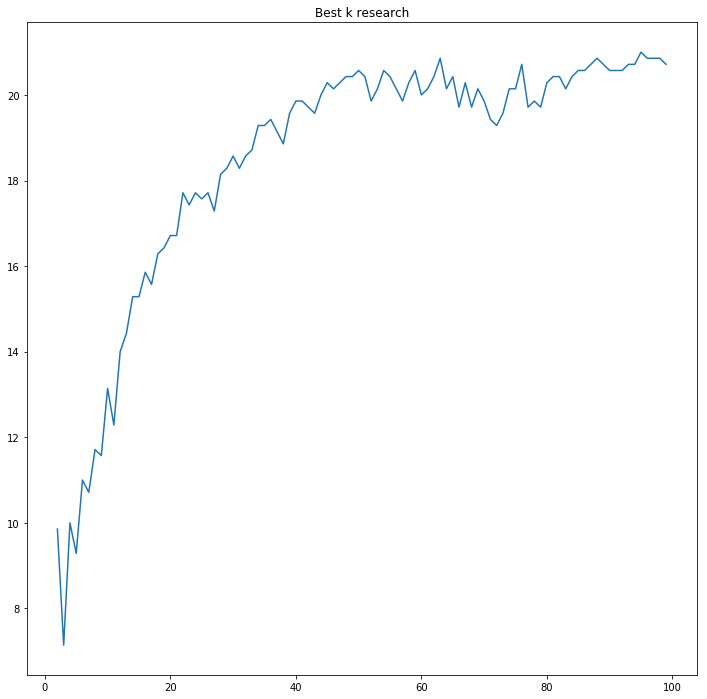

In [227]:
plt.figure(figsize=(12,12))
ax = plt.subplot()
ax.set_title("Best k research")

# Recherche du K ideal
krange = range(2,100)
error=[]
for k in krange:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(xtrain, ytrain)
    error.append(100*(1 - (knn.score(xtest, ytest))))
    
plt.plot(krange, error)

In [228]:
mini = min(error)
mini

7.14285714285714

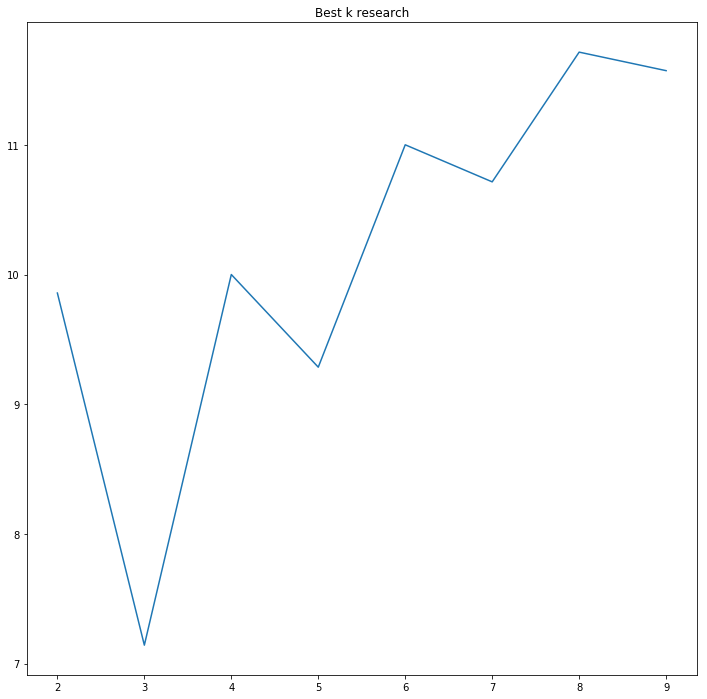

In [229]:
plt.figure(figsize=(12,12))
ax = plt.subplot()
ax.set_title("Best k research")

# Recherche du K ideal
krange = range(2,10)
error=[]
for k in krange:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(xtrain, ytrain)
    error.append(100*(1 - (knn.score(xtest, ytest))))
    
plt.plot(krange, error)

In [230]:
print ("The kNN best Score with Base 1 is",(100 - min(error)), "%, with k= 3")

The kNN best Score with Base 1 is 92.85714285714286 %, with k= 3


In [231]:
mini = min(error)
mini

7.14285714285714

### kNN with Base 2: (Total_Quant, Mean_Quant_pTransaction, Mean_Price_pTransaction, Monetary_value)  --> RFMScore

<strong> Add column of 1

In [232]:
xones = np.ones(X_train2.shape[0])
xones = pd.DataFrame(xones)
xtrain2 = pd.DataFrame(X_train2)
xtrain2 = pd.concat([xones, xtrain2], axis = 1)
xtrain2.head()

,0,0,1,2,3
0,1.0,-0.099082,-0.272960,-0.113620,-0.099889
1,1.0,-0.189126,0.054510,0.037060,-0.132902
2,1.0,-0.234771,-0.270854,-0.237588,-0.223608
3,1.0,0.610207,0.054258,0.236732,0.992386
4,1.0,-0.212650,-0.299075,-0.351764,-0.212191


In [233]:
xones = np.ones(X_test2.shape[0])
xones = pd.DataFrame(xones)
xtest2 = pd.DataFrame(X_test2)
xtest2 = pd.concat([xones, xtest2], axis = 1)
xtest2.head()

,0,0,1,2,3
0,1.0,0.109826,-0.117696,0.067693,0.295614
1,1.0,-0.224801,-0.119095,0.212489,-0.216469
2,1.0,-0.233525,-0.280250,-0.373010,-0.226841
3,1.0,-0.225268,-0.217997,0.349588,-0.207508
4,1.0,0.243645,-0.072331,-0.270065,0.097476


In [234]:
ytrain2 = y_train2
ytest2 = y_test2

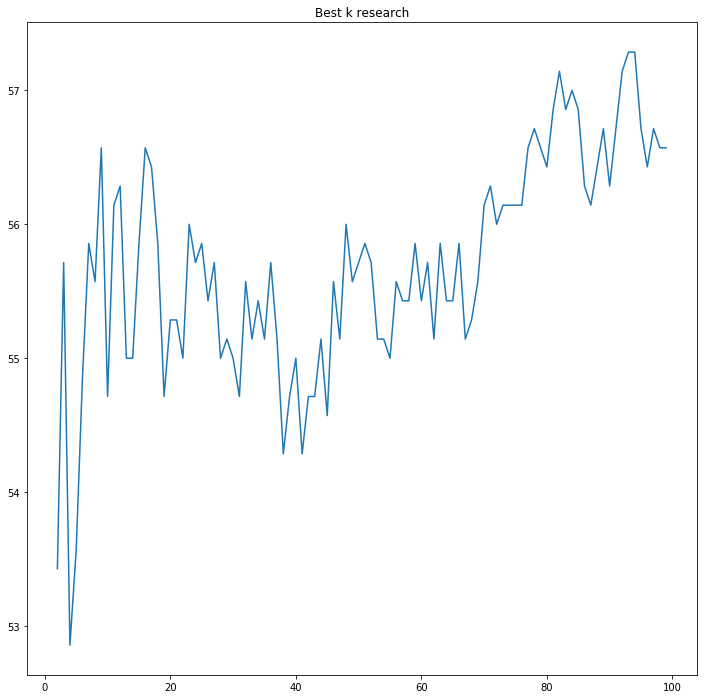

In [235]:
plt.figure(figsize=(12,12))
ax = plt.subplot()
ax.set_title("Best k research")

# Recherche du K ideal
krange = range(2,100)
error=[]
for k in krange:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(xtrain2, ytrain2)
    error.append(100*(1 - (knn.score(xtest2, ytest2))))
    
plt.plot(krange, error)

In [236]:
mini = min(error)
mini

52.85714285714286

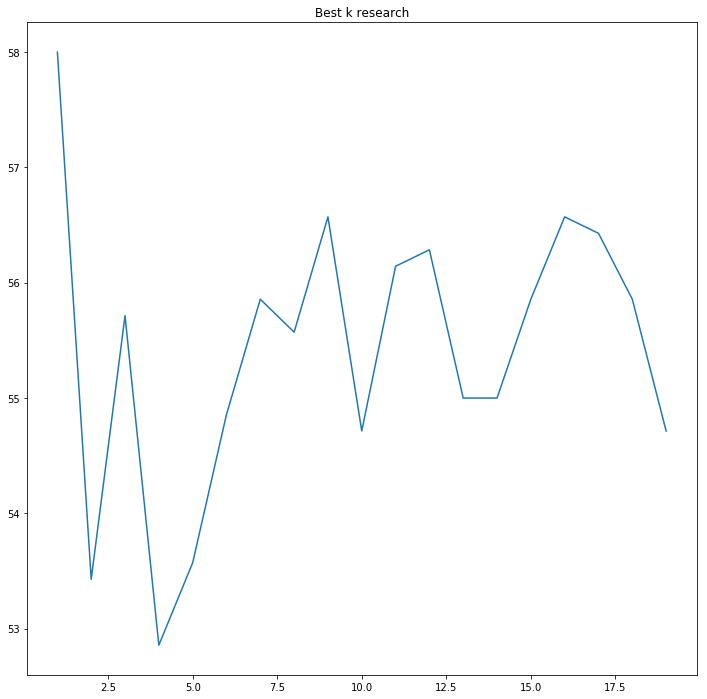

In [237]:
plt.figure(figsize=(12,12))
ax = plt.subplot()
ax.set_title("Best k research")

# Recherche du K ideal
krange = range(1,20)
error=[]
for k in krange:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(xtrain2, ytrain2)
    error.append(100*(1 - (knn.score(xtest2, ytest2))))
    
plt.plot(krange, error)

In [238]:
print ("The kNN best Score with Base 2 is",(100 - min(error)), "%, with k= 4")

The kNN best Score with Base 2 is 47.14285714285714 %, with k= 3


In [239]:
mini = min(error)
mini

52.85714285714286

<span style="color:#3366ff"> Lower error with k = 41.

### kNN with Base 3: ('Total_Quant', 'Mean_Quant_pTransaction', 'Mean_Price_pTransaction', 'Monetary_value')  --> Seg Cat

Add columns of ones

In [240]:
xones = np.ones(X_train3.shape[0])
xones = pd.DataFrame(xones)
xtrain3 = pd.DataFrame(X_train3)
xtrain3 = pd.concat([xones, xtrain3], axis = 1)
xtrain3.head()

,0,0,1,2,3
0,1.0,-0.203770,0.066941,-0.163296,-0.213642
1,1.0,-0.223866,-0.163333,0.235397,-0.191138
2,1.0,-0.118400,-0.206991,-0.234962,-0.168495
3,1.0,0.002645,-0.255363,-0.329796,0.031615
4,1.0,-0.211559,-0.168290,0.329277,-0.192220


In [241]:
xones = np.ones(X_test3.shape[0])
xones = pd.DataFrame(xones)
xtest3 = pd.DataFrame(X_test3)
xtest3 = pd.concat([xones, xtest3], axis = 1)
xtest3.head()

,0,0,1,2,3
0,1.0,-0.227294,-0.302023,-0.251016,-0.220627
1,1.0,0.155938,-0.261979,-0.206031,0.113627
2,1.0,-0.228540,-0.209413,0.425178,-0.213029
3,1.0,-0.037547,-0.044702,-0.447489,-0.123005
4,1.0,-0.214519,-0.185535,-0.223085,-0.201142


In [242]:
ytrain3 = y_train3
ytest3 = y_test3

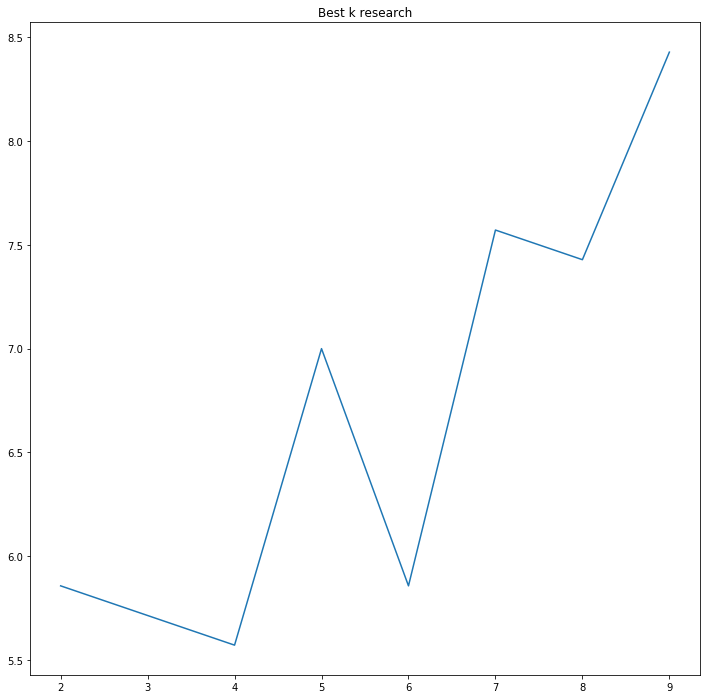

In [243]:
plt.figure(figsize=(12,12))
ax = plt.subplot()
ax.set_title("Best k research")

# Recherche du K ideal
krange = range(2,10)
error=[]
for k in krange:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(xtrain3, ytrain3)
    error.append(100*(1 - (knn.score(xtest3, ytest3))))
    
plt.plot(krange, error)

In [244]:
print ("The kNN best Score with Base 3 is",(100 - min(error)), "%, with k= 4")

The kNN best Score with Base 3 is 94.42857142857143 %, with k= 4


In [245]:
mini = min(error)
mini

5.571428571428571

### kNN with Base 4: (Total_Quant, Monetary_Value)  --> Seg Cat

Add columns of ones

In [246]:
xones = np.ones(X_train4.shape[0])
xones = pd.DataFrame(xones)
xtrain4 = pd.DataFrame(X_train4)
xtrain4 = pd.concat([xones, xtrain4], axis = 1)
xtrain4.head()

,0,0,1
0,1.0,-0.149089,-0.167296
1,1.0,-0.225113,-0.207657
2,1.0,-0.168095,-0.153781
3,1.0,-0.024305,-0.043920
4,1.0,-0.217946,-0.210472


In [247]:
xones = np.ones(X_test4.shape[0])
xones = pd.DataFrame(xones)
xtest4 = pd.DataFrame(X_test4)
xtest4 = pd.concat([xones, xtest4], axis = 1)
xtest4.head()

,0,0,1
0,1.0,-0.219972,-0.214887
1,1.0,-0.238510,-0.224894
2,1.0,0.011525,-0.029035
3,1.0,-0.236485,-0.229484
4,1.0,-0.237731,-0.220290


In [248]:
ytrain4 = y_train4
ytest4 = y_test4

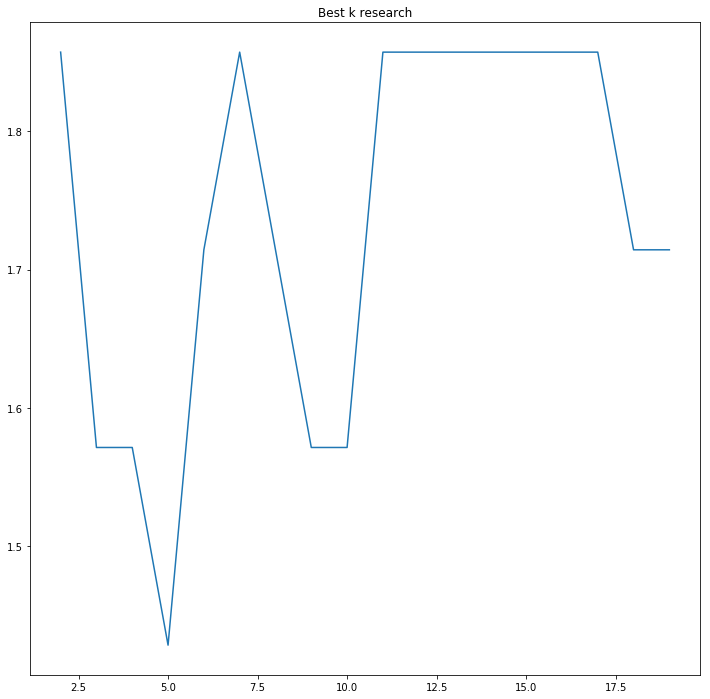

In [249]:
plt.figure(figsize=(12,12))
ax = plt.subplot()
ax.set_title("Best k research")

# Recherche du K ideal
krange = range(2,20)
error=[]
for k in krange:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(xtrain4, ytrain4)
    error.append(100*(1 - (knn.score(xtest4, ytest4))))
    
plt.plot(krange, error)

In [250]:
print ("The kNN best Score with Base 4 is",(100 - min(error)), "%, with k= 5")

The kNN best Score with Base 4 is 98.57142857142858 %, with k= XX


In [251]:
mini = min(error)
mini

1.4285714285714235

# ML CLASSIFICATION:  kNN + Cross Validation

### kNN + CV with Base 1: (Quantity, Recency, Monetary_value)  --> RFMScore

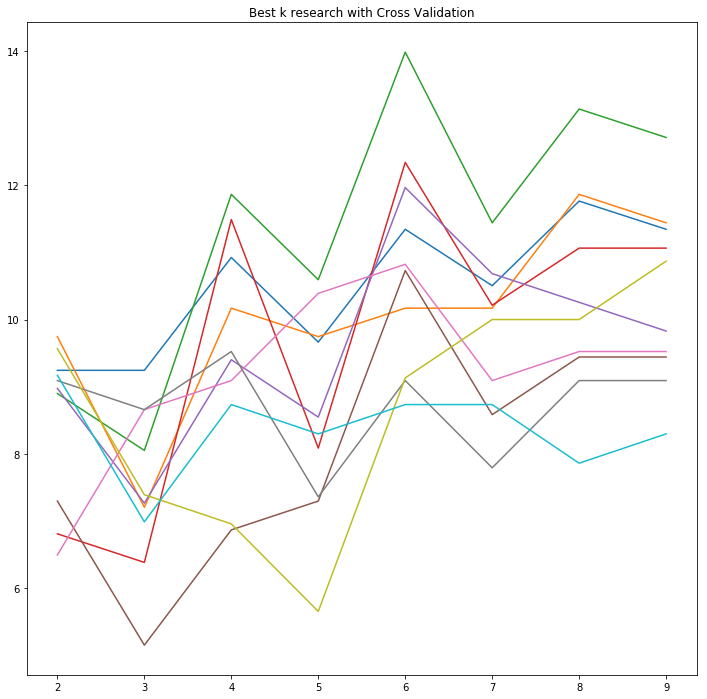

In [252]:
plt.figure(figsize=(12,12))
ax = plt.subplot()
ax.set_title("Best k research with Cross Validation")

krange = range(2,10)
error = []

# perform 10-fold cross validation
for k in krange:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_scaled, data_rfm_rav_y, cv=10, scoring='accuracy')
    error.append(100*(1 - score))
    #y_pred = knn.predict(X_test)
    #cm.append(confusion_matrix(y_test, y_pred))
    
plt.plot(krange, error)

In [253]:
knn = neighbors.KNeighborsClassifier(n_neighbors=k)

parameters = {'n_neighbors' : range(2,10)}

clf_knn = GridSearchCV(knn, parameters, n_jobs=4, cv=10)
clf_knn.fit(X_scaled, data_rfm_rav_y)

print ("The kNN + Cross Validation best Score with Base 1 is",(clf_knn.best_score_)*100,
       "% with the parameter",clf_knn.best_params_) 

The kNN + Cross Validation best Score with Base 1 is 92.49892841834549 % with the parameter {'n_neighbors': 3}


In [254]:
knn_model_estimator = clf_knn.best_estimator_
knn_model_estimator

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [255]:
error_cv = (100*(1 - clf_knn.best_score_))
error_cv

7.501071581654517

In [256]:
knn_model_estimator = clf_knn.best_estimator_
knn_model_estimator

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

<strong> Verification kNN + CV with Base 1

In [257]:
# Meilleur K = 3
knn3 = neighbors.KNeighborsClassifier(n_neighbors=3)
knn3.fit(xtrain, ytrain)
scoreknn3 = knn3.score(xtest, ytest)


print ("The kNN + Cross Validation best Score with best parameters with Base 1 is",scoreknn3*100,".") 

The kNN + Cross Validation best Score with best parameters with Base 1 is 92.85714285714286 .


### kNN + CV with Base 2: ('Total_Quant', 'Mean_Quant_pTransaction', 'Mean_Price_pTransaction', 'Monetary_value')  --> RFMScore

In [258]:
knn = neighbors.KNeighborsClassifier(n_neighbors=k)

parameters = {'n_neighbors' : range(2,10)}

clf_knn2 = GridSearchCV(knn, parameters, n_jobs=4, cv=10)
clf_knn2.fit(X_scaled2, data_rfm_rav_y)

print ("The kNN + Cross Validation best Score with Base 1 is",(clf_knn2.best_score_)*100,
       "% with the parameter",clf_knn2.best_params_,".") 

The kNN + Cross Validation best Score with Base 1 is 46.335190741534504 % with the parameter {'n_neighbors': 9} .


In [259]:
knn_model_estimator2 = clf_knn2.best_estimator_
knn_model_estimator2

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

In [260]:
error_cv2 = (100*(1 - clf_knn2.best_score_))
error_cv2

53.664809258465496

In [261]:
knn_model_estimator2 = clf_knn2.best_estimator_
knn_model_estimator2

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

<strong> Verification kNN + CV with Base 2

In [262]:
# Meilleur K = 9
knn3_2 = neighbors.KNeighborsClassifier(n_neighbors=9)
knn3_2.fit(xtrain2, ytrain2)

pred2 = knn3_2.predict(xtest2)

In [263]:
scoreknn3_2 = knn3_2.score(xtest2, ytest2)
scoreknn3_2 = scoreknn3_2 * 100

print ("The kNN + Cross Validation best Score with best parameters with Base 2 is",scoreknn3_2,".") 

The kNN + Cross Validation best Score with best parameters with Base 2 is 43.42857142857143 .


### kNN + CV with Base 3: ( 'Total_Quant', 'Mean_Quant_pTransaction', 'Mean_Price_pTransaction', 'Monetary_value')  --> Seg Cat 

In [264]:
knn = neighbors.KNeighborsClassifier(n_neighbors=k)

parameters = {'n_neighbors' : range(2,10)}

clf_knn3 = GridSearchCV(knn, parameters, n_jobs=4, cv=10)
clf_knn3.fit(X_scaled3, data_rfm_rav_y2)

print ("The kNN + Cross Validation best Score with Base 3 is",(clf_knn3.best_score_)*100,
       "% with the parameter",clf_knn3.best_params_,".") 

The kNN + Cross Validation best Score with Base 3 is 99.18559794256322 % with the parameter {'n_neighbors': 3} .


In [265]:
knn_model_estimator3 = clf_knn3.best_estimator_
knn_model_estimator3

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [266]:
error_cv3 = (100*(1 - clf_knn3.best_score_))
error_cv3

0.8144020574367805

In [267]:
knn_model_estimator3 = clf_knn3.best_estimator_
knn_model_estimator3

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

### kNN + CV with Base 4: ('Total_Quant', 'Monetary_value' )  --> Seg Cat 

In [268]:
knn = neighbors.KNeighborsClassifier(n_neighbors=k)

parameters = {'n_neighbors' : range(2,10)}

clf_knn4 = GridSearchCV(knn, parameters, n_jobs=4, cv=10)
clf_knn4.fit(X_scaled3, data_rfm_rav_y2)

print ("The kNN + Cross Validation best Score with Base 4 is",(clf_knn4.best_score_)*100,
       "% with the parameter",clf_knn4.best_params_,".") 

The kNN + Cross Validation best Score with Base 4 is 99.18559794256322 % with the parameter {'n_neighbors': 3} .


In [269]:
knn_model_estimator4 = clf_knn4.best_estimator_
knn_model_estimator4

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [270]:
error_cv4 = (100*(1 - clf_knn4.best_score_))
error_cv4

0.8144020574367805

In [271]:
knn_model_estimator4 = clf_knn4.best_estimator_
knn_model_estimator4

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

# ML CLASSIFICATION:  Random Forest Classifier

### RFC with Base 1: ( Quantity, Recency, Monetary_value)  --> RFMScore

In [272]:
rfc = RandomForestClassifier(n_estimators=500)

In [273]:
model = rfc.fit(X_train, y_train)

In [274]:
pred = rfc.predict(X_test)

<strong> Accuracy Random Forest Classifier

In [275]:
print (
    "RFC Accuracy with Base 1 is: ",
    (rfc.score(X_test, y_test))*100, "%."      
)

RFC Accuracy with Base 1 is:  100.0 %.


<strong> Erreur Random Forest Classifier

In [276]:
print (
    "RFC Error with Base 1 is: ",
    (100 - (rfc.score(X_test, y_test))*100),"%."
)

RFC Error with Base 1 is:  0.0 %.


<span style="color:#3366ff"> Very low error.

<strong> Best Parameters Selection 

In [277]:
select = SelectFromModel(rfc, prefit=True, threshold=0.005)
X_train_sel = select.transform(X_train)
X_test_sel = select.transform(X_test)

print(X_train_sel.shape)

(1633, 3)


<Strong> Test with selected parameters

In [278]:
rfc_s = RandomForestClassifier(n_estimators=500, oob_score=True)
model_s = rfc_s.fit(X_train_sel, y_train)

pred_s = rfc_s.predict(X_test_sel)
accuracy_s = accuracy_score(y_test, pred_s)

print ("RFC Accuracy with selected parameters with Base 1 is: ",
    accuracy_s*100, "%." )

RFC Accuracy with selected parameters with Base 1 is:  100.0 %.


In [279]:
print ("RFC Error with selected parameters with Base 1 is: ",
    (1 - accuracy_s)*100, "%."
)

RFC Error with selected parameters with Base 1 is:  0.0 %.


<span style="color:#3366ff"> Same error after best parameters selection.

### RFC with Base 2: ('Total_Quant', 'Mean_Quant_pTransaction', 'Mean_Price_pTransaction', 'Monetary_value')  --> RFMScore

In [280]:
rfc2 = RandomForestClassifier(n_estimators=500)

In [281]:
model2 = rfc2.fit(X_train2, y_train2)

In [282]:
pred2 = rfc2.predict(X_test2)

In [283]:
print ("RFC Accuracy with Base 2 is:",
    (rfc2.score(X_test2, y_test2))*100, "%."
)

RFC Accuracy with Base 2 is: 53.57142857142857 %.


In [284]:
print ("RFC Error with Base 2 is:",
    (1 - (rfc2.score(X_test2, y_test2)))*100, "%."
)

RFC Error with Base 2 is: 46.42857142857143 %.


<strong> Best Parameters Selection 

In [285]:
select2 = SelectFromModel(rfc2, prefit=True, threshold=0.005)
X_train_sel2 = select2.transform(X_train2)
X_test_sel2 = select2.transform(X_test2)

print(X_train_sel2.shape)

(1633, 4)


<Strong> Test with selected parameters

In [286]:
rfc_s2 = RandomForestClassifier(n_estimators=500, oob_score=True)
model_s2 = rfc_s2.fit(X_train_sel2, y_train2)

pred_s2 = rfc_s2.predict(X_test_sel2)
accuracy_s2 = accuracy_score(y_test2, pred_s2)

print ("RFC Accuracy with selected parameters with Base 2 is: ",
    accuracy_s2*100, "%." )

RFC Accuracy with selected parameters with Base 2 is:  52.42857142857142 %.


In [287]:
print ("RFC Error with selected parameters with Base 2 is: ",
    (1 - accuracy_s2)*100, "%."
)

RFC Error with selected parameters with Base 2 is:  47.57142857142858 %.


### RFC with Base 3: ('Total_Quant', 'Mean_Quant_pTransaction', 'Mean_Price_pTransaction', 'Monetary_value' )  --> Seg Cat

In [288]:
rfc3 = RandomForestClassifier(n_estimators=500)

In [289]:
model3 = rfc3.fit(X_train3, y_train3)

In [290]:
pred3 = rfc3.predict(X_test3)

In [291]:
print ("RFC Accuracy with Base 3 is:",
    (rfc3.score(X_test3, y_test3))*100, "%."
)

RFC Accuracy with Base 3 is: 100.0 %.


### RFC with Base 4: ('Total_Quant', 'Monetary_value' )  --> Seg Cat

In [292]:
rfc4 = RandomForestClassifier(n_estimators=500)

In [293]:
model4 = rfc4.fit(X_train4, y_train4)

In [294]:
pred4 = rfc4.predict(X_test4)

In [295]:
print ("RFC Accuracy with Base 4 is:",
    (rfc4.score(X_test4, y_test4))*100, "%."
)

RFC Accuracy with Base 4 is: 100.0 %.


# ML CLASSIFICATION:  Random Forest Classifier + Cross Validation

### RFC + CV with Base 1: ( Quantity, Recency, Monetary_value)  --> RFMScore

<strong> test1

In [296]:
rfcCV = RandomForestClassifier(n_estimators=500)

scoresCV = cross_val_score(rfcCV, X_scaled, data_rfm_rav_y, cv=10, scoring='accuracy')
scoresCV

array([1.        , 1.        , 0.99576271, 1.        , 1.        ,
       1.        , 1.        , 0.99134199, 1.        , 1.        ])

In [297]:
print("RFC + CV with Base 1 Accuracy is: %0.2f (+/- %0.2f)" % (scoresCV.mean(), scoresCV.std() * 2))

RFC + CV with Base 1 Accuracy is: 1.00 (+/- 0.01)


In [298]:
mean_error = (1 - scoresCV.mean())*100

print("RFC + CV with Base 1 Mean Error is", mean_error,"%.")

RFC + CV with Base 1 Mean Error is 0.12895296793601352 %.


<strong> test2

In [299]:
rfcCV = RandomForestClassifier()

parameters = {
              'n_estimators': [100, 200, 300, 400, 500],
              'max_depth':range(3,5)
             }

clf = GridSearchCV(rfcCV, parameters, n_jobs=4, cv=10)
clf.fit(X_scaled, data_rfm_rav_y)

print ("The RFC + CV Accuracy with Base 1 is:",
    (clf.best_score_*100), 
      "% with parameters:", 
    clf.best_params_) 

The RFC + CV Accuracy with Base 1 is: 99.95713673381911 % with parameters: {'max_depth': 4, 'n_estimators': 100}


In [300]:
clf

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': [100, 200, 300, 400, 500], 'max_depth': range(3, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [301]:
tree_best_estim = clf.best_estimator_
tree_best_estim

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [302]:
tree_best_para = clf.best_params_
tree_best_para

{'max_depth': 4, 'n_estimators': 100}

In [303]:
tree_best_scor = clf.grid_scores_
tree_best_scor

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.92242, std: 0.02613, params: {'max_depth': 3, 'n_estimators': 100},
 mean: 0.93613, std: 0.00270, params: {'max_depth': 3, 'n_estimators': 200},
 mean: 0.93656, std: 0.00207, params: {'max_depth': 3, 'n_estimators': 300},
 mean: 0.93613, std: 0.00270, params: {'max_depth': 3, 'n_estimators': 400},
 mean: 0.93699, std: 0.00216, params: {'max_depth': 3, 'n_estimators': 500},
 mean: 0.99957, std: 0.00127, params: {'max_depth': 4, 'n_estimators': 100},
 mean: 0.99957, std: 0.00127, params: {'max_depth': 4, 'n_estimators': 200},
 mean: 0.99957, std: 0.00127, params: {'max_depth': 4, 'n_estimators': 300},
 mean: 0.99957, std: 0.00127, params: {'max_depth': 4, 'n_estimators': 400},
 mean: 0.99957, std: 0.00127, params: {'max_depth': 4, 'n_estimators': 500}]

<strong> Verification

In [304]:
rfcBest = RandomForestClassifier(n_estimators=100, max_depth=4)

modelBest = rfcBest.fit(X_train, y_train)
predBest = rfcBest.predict(X_test)

print ("The RFC + CV Accuracy with BEST PARAMETERS with Base 1 is:",
    (accuracy_score(y_test, predBest))*100, "%."
)

The RFC + CV Accuracy with BEST PARAMETERS with Base 1 is: 100.0 %.


### RFC + CV with Base 2: ( 'Total_Quant', 'Mean_Quant_pTransaction', 'Mean_Price_pTransaction', 'Monetary_value')  --> RFMScore

In [305]:
rfcCV2 = RandomForestClassifier()

parameters = {
              'n_estimators': [100, 200, 300, 400, 500],
              'max_depth':range(3,5)
             }

clfCV2 = GridSearchCV(rfcCV2, parameters, n_jobs=4, cv=10)
clfCV2.fit(X_scaled2, data_rfm_rav_y)

print ("The RFC + CV Accuracy with Base 2 is:",
    (clfCV2.best_score_*100), 
      "% with parameters:", 
    clfCV2.best_params_) 

The RFC + CV Accuracy with Base 2 is: 56.622374624946424 % with parameters: {'max_depth': 4, 'n_estimators': 500}


In [306]:
tree_best_estim2 = clfCV2.best_estimator_
tree_best_estim2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [307]:
tree_best_para2 = clfCV2.best_params_
tree_best_para2

{'max_depth': 4, 'n_estimators': 500}

In [308]:
tree_best_scor2 = clfCV2.grid_scores_
tree_best_scor2

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.55851, std: 0.00872, params: {'max_depth': 3, 'n_estimators': 100},
 mean: 0.56108, std: 0.00946, params: {'max_depth': 3, 'n_estimators': 200},
 mean: 0.56194, std: 0.00906, params: {'max_depth': 3, 'n_estimators': 300},
 mean: 0.55894, std: 0.00959, params: {'max_depth': 3, 'n_estimators': 400},
 mean: 0.56151, std: 0.00895, params: {'max_depth': 3, 'n_estimators': 500},
 mean: 0.56451, std: 0.01176, params: {'max_depth': 4, 'n_estimators': 100},
 mean: 0.56151, std: 0.00800, params: {'max_depth': 4, 'n_estimators': 200},
 mean: 0.56022, std: 0.01199, params: {'max_depth': 4, 'n_estimators': 300},
 mean: 0.56451, std: 0.01089, params: {'max_depth': 4, 'n_estimators': 400},
 mean: 0.56622, std: 0.01038, params: {'max_depth': 4, 'n_estimators': 500}]

<strong> Verification

In [367]:
rfcBest2 = RandomForestClassifier(n_estimators=500, max_depth=4)

modelBest2 = rfcBest2.fit(X_train2, y_train2)
predBest2 = rfcBest2.predict(X_test2)

print ("The RFC + CV Accuracy with BEST PARAMETERS with Base 2 is:",
    (accuracy_score(y_test2, predBest2))*100,"%."
)

The RFC + CV Accuracy with BEST PARAMETERS with Base 2 is: 57.285714285714285 %.


### RFC + CV with Base 3: ( 'Total_Quant', 'Mean_Quant_pTransaction', 'Mean_Price_pTransaction', 'Monetary_value')  --> Seg Cat 

In [310]:
rfcCV3 = RandomForestClassifier()

parameters = {
              'n_estimators': [100,110,120,130,150, 200, 300],
              'max_depth':range(3,5)
             }

clfCV3 = GridSearchCV(rfcCV3, parameters, n_jobs=4, cv=10)
clfCV3.fit(X_scaled2, data_rfm_rav_y2)

print ("The RFC + CV Accuracy with Base 3 is:",
    (clfCV3.best_score_*100), 
      "% with parameters:", 
    clfCV3.best_params_) 

The RFC + CV Accuracy with Base 3 is: 99.95713673381911 % with parameters: {'max_depth': 3, 'n_estimators': 100}


<strong> Verification

In [311]:
rfcBest3 = RandomForestClassifier(n_estimators=100, max_depth=3)



The RFC + CV Accuracy with BEST PARAMETERS with Base 3 is: 100.0 %.


### RFC + CV with Base 4: ('Total_Quant', 'Monetary_value' )  --> Seg Cat

In [312]:
rfcCV4 = RandomForestClassifier()

parameters = {
              'n_estimators': [100,110,120,130,150, 200, 300],
              'max_depth':range(3,5)
             }

clfCV4 = GridSearchCV(rfcCV4, parameters, n_jobs=4, cv=10)
clfCV4.fit(X_scaled3, data_rfm_rav_y2)

print ("The RFC + CV Accuracy with Base 4 is:",
    (clfCV4.best_score_*100), 
      "% with parameters:", 
    clfCV4.best_params_) 

The RFC + CV Accuracy with Base 4 is: 99.95713673381911 % with parameters: {'max_depth': 3, 'n_estimators': 100}


<strong> Verification

In [313]:
rfcBest4 = RandomForestClassifier(n_estimators=100, max_depth=3)

modelBest4 = rfcBest4.fit(X_train4, y_train4)
predBest4 = rfcBest4.predict(X_test4)

print ("The RFC + CV Accuracy with BEST PARAMETERS with Base 4 is:",
    (accuracy_score(y_test3, predBest3))*100,"%."
)

The RFC + CV Accuracy with BEST PARAMETERS with Base 4 is: 100.0 %.


# ML CLASSIFICATION: Gradient Boost + Cross Validation

### Gradient Boost + CV with Base 1: ( Quantity, Recency, Monetary_value)  --> RFMScore

In [314]:
gbCV1 = GradientBoostingClassifier()

parameters = {
              'n_estimators': [100,110,120,150,200,300,400,500],
              'max_depth':range(3,5)
             }

clfGB1 = GridSearchCV(gbCV1, parameters, n_jobs=4, cv=10)
clfGB1.fit(X_scaled, data_rfm_rav_y)

print ("The GB + CV Accuracy with Base 1 is:",
    (clfGB1.best_score_*100), 
      "% with parameters:", 
    clfGB1.best_params_) 

The GB + CV Accuracy with Base 1 is: 99.65709387055294 % with parameters: {'max_depth': 3, 'n_estimators': 100}


In [315]:
GB_best_estim = clfGB1.best_estimator_
GB_best_estim

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [316]:
GB_best_para = clfGB1.best_params_
GB_best_para

{'max_depth': 3, 'n_estimators': 100}

In [317]:
GB_best_scor = clfGB1.grid_scores_
GB_best_scor

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.99657, std: 0.00418, params: {'max_depth': 3, 'n_estimators': 100},
 mean: 0.99657, std: 0.00418, params: {'max_depth': 3, 'n_estimators': 110},
 mean: 0.99657, std: 0.00418, params: {'max_depth': 3, 'n_estimators': 120},
 mean: 0.99657, std: 0.00418, params: {'max_depth': 3, 'n_estimators': 150},
 mean: 0.99657, std: 0.00418, params: {'max_depth': 3, 'n_estimators': 200},
 mean: 0.99657, std: 0.00418, params: {'max_depth': 3, 'n_estimators': 300},
 mean: 0.99657, std: 0.00418, params: {'max_depth': 3, 'n_estimators': 400},
 mean: 0.99657, std: 0.00418, params: {'max_depth': 3, 'n_estimators': 500},
 mean: 0.99614, std: 0.00445, params: {'max_depth': 4, 'n_estimators': 100},
 mean: 0.99614, std: 0.00445, params: {'max_depth': 4, 'n_estimators': 110},
 mean: 0.99614, std: 0.00445, params: {'max_depth': 4, 'n_estimators': 120},
 mean: 0.99614, std: 0.00445, params: {'max_depth': 4, 'n_estimators': 150},
 mean: 0.99614, std: 0.00445, params: {'max_depth': 4, 'n_estimators': 200},

<strong> Verification

In [318]:
gbCV1 = GradientBoostingClassifier(n_estimators = 3, max_depth = 100)

modelBest = gbCV1.fit(X_train, y_train)
predBest = gbCV1.predict(X_test)

print ("The GB + CV Accuracy with BEST PARAMETERS with Base 1 is:",
    (accuracy_score(y_test, predBest))*100, "%."
)

The GB + CV Accuracy with BEST PARAMETERS with Base 1 is: 100.0 %.


### Gradient Boost + CV with Base 2: ( 'Total_Quant', 'Mean_Quant_pTransaction', 'Mean_Price_pTransaction', 'Monetary_value')  --> RFMScore

In [319]:
gbCV2 = GradientBoostingClassifier()

parameters = {
              'n_estimators': [100,110,120,150,200,300,400,500],
              'max_depth':range(3,5)
             }

clfGB2 = GridSearchCV(gbCV2, parameters, n_jobs=4, cv=10)
clfGB2.fit(X_scaled2, data_rfm_rav_y)

print ("The GB + CV Accuracy with Base 2 is: ",
    (clfGB2.best_score_*100), 
      "% with parameters:", 
    clfGB2.best_params_) 

The GB + CV Accuracy with Base 2 is:  52.29318474067723 % with parameters: {'max_depth': 3, 'n_estimators': 100}


In [320]:
GB_best_estim2 = clfGB2.best_estimator_
GB_best_estim2

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [321]:
GB_best_para2 = clfGB2.best_params_
GB_best_para2

{'max_depth': 3, 'n_estimators': 100}

In [322]:
GB_best_scor2 = clfGB2.grid_scores_
GB_best_scor2

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.52293, std: 0.02543, params: {'max_depth': 3, 'n_estimators': 100},
 mean: 0.51907, std: 0.03011, params: {'max_depth': 3, 'n_estimators': 110},
 mean: 0.51993, std: 0.03404, params: {'max_depth': 3, 'n_estimators': 120},
 mean: 0.51136, std: 0.02762, params: {'max_depth': 3, 'n_estimators': 150},
 mean: 0.50279, std: 0.02921, params: {'max_depth': 3, 'n_estimators': 200},
 mean: 0.50236, std: 0.03149, params: {'max_depth': 3, 'n_estimators': 300},
 mean: 0.49807, std: 0.03117, params: {'max_depth': 3, 'n_estimators': 400},
 mean: 0.49636, std: 0.03323, params: {'max_depth': 3, 'n_estimators': 500},
 mean: 0.51907, std: 0.03342, params: {'max_depth': 4, 'n_estimators': 100},
 mean: 0.51650, std: 0.03039, params: {'max_depth': 4, 'n_estimators': 110},
 mean: 0.51522, std: 0.02545, params: {'max_depth': 4, 'n_estimators': 120},
 mean: 0.50879, std: 0.02254, params: {'max_depth': 4, 'n_estimators': 150},
 mean: 0.50493, std: 0.02514, params: {'max_depth': 4, 'n_estimators': 200},

<strong> Verification

In [368]:
gbCV2 = GradientBoostingClassifier(n_estimators= 100, max_depth = 3)

modelBest2 = gbCV2.fit(X_train2, y_train2)
predBest2 = gbCV2.predict(X_test2)

print ("The GB + CV Accuracy with BEST PARAMETERS with Base 2 is:",
    (accuracy_score(y_test2, predBest2))*100
)

The GB + CV Accuracy with BEST PARAMETERS with Base 2 is: 52.0


### Gradient Boost + CV with Base 3: ( 'Total_Quant', 'Mean_Quant_pTransaction', 'Mean_Price_pTransaction', 'Monetary_value')  --> Seg Cat

In [324]:
gbCV3 = GradientBoostingClassifier()

parameters = {
              'n_estimators': [100,110,120,150,200,300,400,500],
              'max_depth':range(3,5)
             }

clfGB3 = GridSearchCV(gbCV3, parameters, n_jobs=4, cv=10)
clfGB3.fit(X_scaled2, data_rfm_rav_y2)

print ("The GB + CV Accuracy with Base 2 is: ",
    (clfGB3.best_score_*100), 
      "% with parameters:", 
    clfGB3.best_params_) 

The GB + CV Accuracy with Base 2 is:  99.95713673381911 % with parameters: {'max_depth': 3, 'n_estimators': 100}


<strong> Verification

In [325]:
gbCV3 = GradientBoostingClassifier(n_estimators= 100, max_depth = 3)

modelBest3 = gbCV3.fit(X_train3, y_train3)
predBest3 = gbCV3.predict(X_test3)

print ("The GB + CV Accuracy with BEST PARAMETERS with Base 3 is:",
    (accuracy_score(y_test3, predBest3))*100
)

The GB + CV Accuracy with BEST PARAMETERS with Base 3 is: 99.85714285714286


### Gradient Boost + CV with Base 4: ('Total_Quant', 'Monetary_value' )  --> Seg Cat

In [326]:
gbCV4 = GradientBoostingClassifier()

parameters = {
              'n_estimators': [100,110,120,150,200,300,400,500],
              'max_depth':range(3,5)
             }

clfGB4 = GridSearchCV(gbCV4, parameters, n_jobs=4, cv=10)
clfGB4.fit(X_scaled3, data_rfm_rav_y2)

print ("The GB + CV Accuracy with Base 4 is: ",
    (clfGB4.best_score_*100), 
      "% with parameters:", 
    clfGB4.best_params_) 

The GB + CV Accuracy with Base 4 is:  99.95713673381911 % with parameters: {'max_depth': 3, 'n_estimators': 100}


<strong> Verification

In [327]:
gbCV4 = GradientBoostingClassifier(n_estimators= 100, max_depth = 3)

modelBest4 = gbCV4.fit(X_train4, y_train4)
predBest4 = gbCV4.predict(X_test4)

print ("The GB + CV Accuracy with BEST PARAMETERS with Base 4 is:",
    (accuracy_score(y_test4, predBest4))*100
)

The GB + CV Accuracy with BEST PARAMETERS with Base 4 is: 100.0


# ML CLASSIFICATION:  Ridge + CV

### Ridge + CV with Base 1: (Quantity, Recency, Monetary_value)  --> RFMScore

In [328]:
R_CV = RidgeCV(alphas=(0.1, 1.0, 10.0), 
                     fit_intercept=True, 
                     normalize=False, 
                     scoring=None, 
                     cv=10, 
                     gcv_mode='auto', 
                     store_cv_values=False)    
    
    
# exécuter la validation croisée sur le jeu d'entraînement
R_CV.fit(X_scaled, data_rfm_rav_y)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=10, fit_intercept=True, gcv_mode='auto',
    normalize=False, scoring=None, store_cv_values=False)

In [329]:
R_CV.coef_

array([-1.17658039, -1.22341424,  0.05556979])

<strong> test

In [330]:
rCV1 = Ridge()

n_alphas = 200
alpha_range = np.logspace(0, 8, n_alphas)

parameters = {
              'alpha': alpha_range,
              }

clfR1 = GridSearchCV(rCV1, parameters, n_jobs=4, cv=10)
clfR1.fit(X_scaled, data_rfm_rav_y)

print ("The Ridge + CV Accuracy with Base 1 is:",
    (clfR1.best_score_*100), 
      "% with parameters:", 
    clfR1.best_params_) 

The Ridge + CV Accuracy with Base 1 is: 19.865098742798843 % with parameters: {'alpha': 162.5755666443795}


In [331]:
R_best_estim = clfR1.best_estimator_
R_best_estim

Ridge(alpha=162.5755666443795, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [332]:
R_best_para = clfR1.best_params_
R_best_para

{'alpha': 162.5755666443795}

In [333]:
R_best_scor = clfR1.best_score_
R_best_scor

0.19865098742798842

<strong> Verification

In [369]:
r1 = Ridge(alpha=162.57, 
      fit_intercept=True, 
      normalize=False, 
      copy_X=True, 
      max_iter=None, 
      tol=0.001, solver='auto', random_state=None)

modelBest = r1.fit(X_train, y_train)
predBest = r1.predict(X_test)

print ("The Ridge + CV Accuracy with BEST PARAMETERS with Base 1 is:",
    r1.score(X_test, y_test)*100, "%."
)

The Ridge + CV Accuracy with BEST PARAMETERS with Base 1 is: 22.604420643079425 %.


### Ridge + CV with Base 2: ('Total_Quant', 'Mean_Quant_pTransaction', 'Mean_Price_pTransaction', 'Monetary_value')  --> RFMScore

In [335]:
rCV2 = Ridge()

n_alphas = 200
alpha_range = np.logspace(0, 8, n_alphas)

parameters = {
              'alpha': alpha_range,
              }

clfR2 = GridSearchCV(rCV2, parameters, n_jobs=4, cv=10)
clfR2.fit(X_scaled2, data_rfm_rav_y)

print ("The Ridge + CV Accuracy with Base 2 is:",
    (clfR2.best_score_*100), 
      "% with parameters:", 
    clfR2.best_params_) 

The Ridge + CV Accuracy with Base 2 is: 0.8752589469452741 % with parameters: {'alpha': 1135.7333583431052}


In [336]:
R_best_estim2 = clfR2.best_estimator_
R_best_estim2

Ridge(alpha=1135.7333583431052, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [337]:
R_best_para2 = clfR2.best_params_
R_best_para2

{'alpha': 1135.7333583431052}

In [338]:
R_best_scor2 = clfR2.best_score_
R_best_scor2

0.00875258946945274

<strong> Verification

In [339]:
r2 = Ridge(alpha=1135.0, 
      fit_intercept=True, 
      normalize=False, 
      copy_X=True, 
      max_iter=None, 
      tol=0.001, solver='auto', random_state=None)

modelBest2 = r2.fit(X_train2, y_train2)
predBest2 = r2.predict(X_test2)

print ("The Ridge + CV Accuracy with BEST PARAMETERS with Base 2 is:",
    (r2.score(X_test2, y_test2))*100,"%."
)

The Ridge + CV Accuracy with BEST PARAMETERS with Base 2 is: 1.8057108407341649 %.


### Ridge + CV with Base 3: ('Total_Quant', 'Mean_Quant_pTransaction', 'Mean_Price_pTransaction', 'Monetary_value' )  --> Seg Cat

In [340]:
rCV3 = Ridge()

n_alphas = 200
alpha_range = np.logspace(0, 8, n_alphas)

parameters = {
              'alpha': alpha_range,
              }

clfR3 = GridSearchCV(rCV3, parameters, n_jobs=4, cv=10)
clfR3.fit(X_scaled2, data_rfm_rav_y2)

print ("The Ridge + CV Accuracy with Base 3 is:",
    (clfR3.best_score_*100), 
      "% with parameters:", 
    clfR3.best_params_) 

The Ridge + CV Accuracy with Base 3 is: 7.291876642882049 % with parameters: {'alpha': 1245.883364295008}


<strong> Verification

In [370]:
r3 = Ridge(alpha=1245.0, 
      fit_intercept=True, 
      normalize=False, 
      copy_X=True, 
      max_iter=None, 
      tol=0.001, solver='auto', random_state=None)

modelBest3 = r3.fit(X_train3, y_train3)
predBest3 = r3.predict(X_test3)

print ("The Ridge + CV Accuracy with BEST PARAMETERS with Base 3 is:",
    (r3.score(X_test3, y_test3))*100,"%."
)

The Ridge + CV Accuracy with BEST PARAMETERS with Base 3 is: 8.79075019289649 %.


### Ridge + CV with Base 4: ( 'Total_Quant', 'Monetary_value')  --> Seg Cat

In [342]:
rCV4 = Ridge()

n_alphas = 200
alpha_range = np.logspace(0, 8, n_alphas)

parameters = {
              'alpha': alpha_range,
              }

clfR4 = GridSearchCV(rCV4, parameters, n_jobs=4, cv=10)
clfR4.fit(X_scaled3, data_rfm_rav_y2)

print ("The Ridge + CV Accuracy with Base 4 is:",
    (clfR4.best_score_*100), 
      "% with parameters:", 
    clfR4.best_params_) 

The Ridge + CV Accuracy with Base 4 is: 6.884078109852146 % with parameters: {'alpha': 1245.883364295008}


<strong> Verification

In [371]:
r4 = Ridge(alpha=1245.8, 
      fit_intercept=True, 
      normalize=False, 
      copy_X=True, 
      max_iter=None, 
      tol=0.001, solver='auto', random_state=None)

modelBest4 = r4.fit(X_train4, y_train4)
predBest4 = r4.predict(X_test4)

print ("The Ridge + CV Accuracy with BEST PARAMETERS with Base 4 is:",
    (r4.score(X_test4, y_test4))*100,"%."
)

The Ridge + CV Accuracy with BEST PARAMETERS with Base 4 is: 4.516341173051341 %.


# ML CLASSIFICATION:  Ridge à NOYAU + Cross Validation

### Ridge à Noyau + CV with Base 1: (Quantity, Recency, Monetary_value)  --> RFMScore

In [344]:
# valeurs du paramètre C
alpha_range = np.logspace(-2, 2, 5)

# valeurs du paramètre gamma
gamma_range = np.logspace(-2, 1, 5)

# grille de paramètres
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}

# score pour sélectionner le modèle optimal
score = 'neg_mean_squared_error'

# initialiser la validation croisée
grid_pred = model_selection.GridSearchCV(kernel_ridge.KernelRidge(kernel='rbf'),
                                    param_grid,
                                    cv=5,
                                    scoring=score)
                                    
# exécuter la validation croisée sur le jeu d'entraînement
grid_pred.fit(X_scaled, data_rfm_rav_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'gamma': array([ 0.01   ,  0.05623,  0.31623,  1.77828, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [345]:
accuracy = grid_pred.best_score_

print ("The Kernel Ridge + Cross Validation best Score with Base 1 is",(accuracy*100),
       "% with the parameter",grid_pred.best_params_) 

The Kernel Ridge + Cross Validation best Score with Base 1 is -100.66517537797274 % with the parameter {'alpha': 0.01, 'gamma': 10.0}


In [346]:
grid_pred

GridSearchCV(cv=5, error_score='raise',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'gamma': array([ 0.01   ,  0.05623,  0.31623,  1.77828, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [347]:
kernel_ridge_best_estim = grid_pred.best_estimator_
kernel_ridge_best_estim

KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=10.0, kernel='rbf',
      kernel_params=None)

In [348]:
kernel_ridge_best_params = grid_pred.best_params_
kernel_ridge_best_params

{'alpha': 0.01, 'gamma': 10.0}

In [349]:
kernel_ridge_best_score_ = grid_pred.best_score_
kernel_ridge_best_score_ 

-1.0066517537797275

<span style="color:#3366ff"> NOK !

<strong> Verification

In [350]:
predicteur = kernel_ridge.KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=10, kernel='rbf', kernel_params=None)

predicteur.fit(X_train, y_train)
#pred = predicteur.predict(X_test)

KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=10, kernel='rbf',
      kernel_params=None)

In [351]:
accuracy = predicteur.score(X_test, y_test)

print ("The Kernel Ridge + CV Accuracy with BEST PARAMETERS with Base 1 is:",accuracy*100)

The Kernel Ridge + CV Accuracy with BEST PARAMETERS with Base 1 is: 88.12818137575243


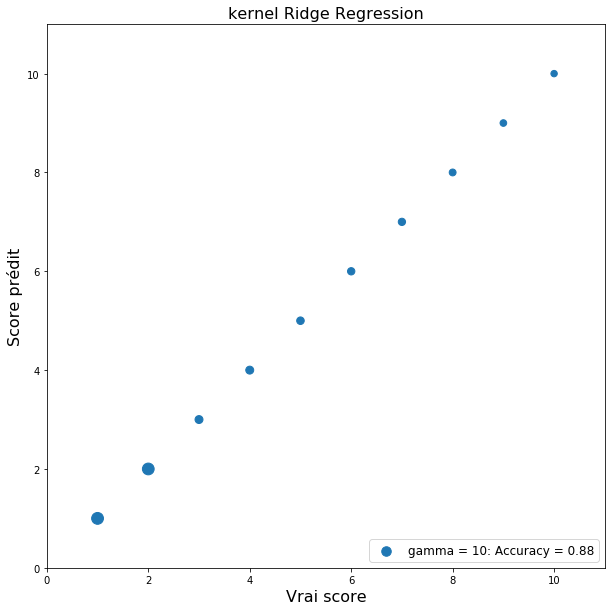

In [352]:
fig = plt.figure(figsize=(10, 10))

# Compter, pour chaque paire de valeurs (y, y') où y est un vrai score et y' le score prédit,
# le nombre de ces paires.
# Ce nombre sera utilisé pour modifier la taille des marqueurs correspondants 
# dans un nuage de points
sizes = {}
for (yt, yp) in zip(list(y_test), list(pred)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1        
keys = sizes.keys()

# afficher les prédictions
plt.scatter([k[0] for k in keys], 
            [k[1] for k in keys], 
             s=[sizes[k] for k in keys], 
            label='gamma = 10: Accuracy = %0.2f' % accuracy)

# étiqueter les axes et le graphique
plt.xlabel('Vrai score', fontsize=16)
plt.ylabel(u'Score prédit', fontsize=16)
plt.title('kernel Ridge Regression', fontsize=16)

# limites des axes
plt.xlim([0, 11])
plt.ylim([0, 11])

# afficher la légende
plt.legend(loc="lower right", fontsize=12)

<span style="color:#3366ff"> T

### Ridge à Noyau + CV with Base 2: ('Total_Quant', 'Mean_Quant_pTransaction', 'Mean_Price_pTransaction', 'Monetary_value')  --> RFMScore

In [353]:
# valeurs du paramètre C
alpha_range = np.logspace(-2, 2, 5)

# valeurs du paramètre gamma
gamma_range = np.logspace(-2, 1, 4)

# grille de paramètres
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}

# score pour sélectionner le modèle optimal
score = 'neg_mean_squared_error'

# initialiser la validation croisée
grid_pred2 = model_selection.GridSearchCV(kernel_ridge.KernelRidge(kernel='rbf'),
                                    param_grid,
                                    cv=5,
                                    scoring=score)
                                    
# exécuter la validation croisée sur le jeu d'entraînement
grid_pred2.fit(X_scaled2, data_rfm_rav_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'gamma': array([ 0.01,  0.1 ,  1.  , 10.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [354]:
accuracy2 = grid_pred2.score(X_test2, y_test2)

print ("The Kernel Ridge + Cross Validation best Score with Base 2 is",(grid_pred2.best_score_*100),
       "% with the parameter",grid_pred2.best_params_) 

The Kernel Ridge + Cross Validation best Score with Base 2 is -687.4573230540219 % with the parameter {'alpha': 1.0, 'gamma': 10.0}


<span style="color:#3366ff"> NOK !

In [355]:
grid_pred2

GridSearchCV(cv=5, error_score='raise',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'gamma': array([ 0.01,  0.1 ,  1.  , 10.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [356]:
kernel_ridge_best_estim = grid_pred2.best_estimator_
kernel_ridge_best_estim

KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=10.0, kernel='rbf',
      kernel_params=None)

In [357]:
kernel_ridge_best_params = grid_pred2.best_params_
kernel_ridge_best_params

{'alpha': 1.0, 'gamma': 10.0}

In [358]:
kernel_ridge_best_score_ = grid_pred2.best_score_

print ("The Kernel Ridge + Cross Validation best Score with Base 2 is",(grid_pred2.best_score_*100),
       "% with the parameter",grid_pred2.best_params_) 

The Kernel Ridge + Cross Validation best Score with Base 2 is -687.4573230540219 % with the parameter {'alpha': 1.0, 'gamma': 10.0}


<span style="color:#3366ff"> NOK !

<strong> Verification

In [359]:
predicteur2 = kernel_ridge.KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=10, kernel='rbf', kernel_params=None)
predicteur2.fit(X_train2, y_train2)
#pred2 = predicteur2.predict(X_test2)

accuracy2 = predicteur2.score(X_test2, y_test2)

print ("The Kernel Ridge + CV Accuracy with BEST PARAMETERS with Base 2 is:",
    accuracy2*100)

The Kernel Ridge + CV Accuracy with BEST PARAMETERS with Base 2 is: 22.18515303115236


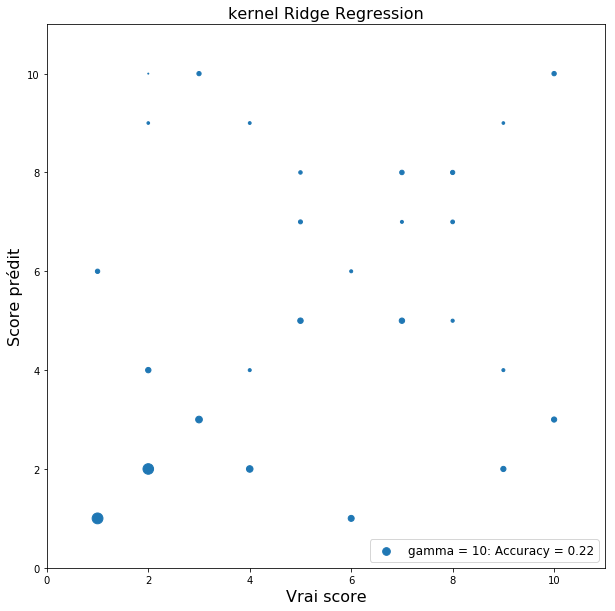

In [360]:
fig = plt.figure(figsize=(10, 10))

# Compter, pour chaque paire de valeurs (y, y') où y est un vrai score et y' le score prédit,
# le nombre de ces paires.
# Ce nombre sera utilisé pour modifier la taille des marqueurs correspondants 
# dans un nuage de points
sizes = {}
for (yt, yp) in zip(list(y_test2), list(pred2)):
    if (yt, yp) in sizes:
        sizes[(yt, yp)] += 1
    else:
        sizes[(yt, yp)] = 1        
keys = sizes.keys()

# afficher les prédictions
plt.scatter([k[0] for k in keys], 
            [k[1] for k in keys], 
             s=[sizes[k] for k in keys], 
            label='gamma = 10: Accuracy = %0.2f' % accuracy2)

# étiqueter les axes et le graphique
plt.xlabel('Vrai score', fontsize=16)
plt.ylabel(u'Score prédit', fontsize=16)
plt.title('kernel Ridge Regression', fontsize=16)

# limites des axes
plt.xlim([0, 11])
plt.ylim([0, 11])

# afficher la légende
plt.legend(loc="lower right", fontsize=12)

### Ridge à Noyau + CV with Base 3: ('Total_Quant', 'Mean_Quant_pTransaction', 'Mean_Price_pTransaction', 'Monetary_value')  --> Seg Cat

In [361]:
# valeurs du paramètre C
alpha_range = np.logspace(-2, 2, 5)

# valeurs du paramètre gamma
gamma_range = np.logspace(-2, 1, 4)

# grille de paramètres
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}

# score pour sélectionner le modèle optimal
score = 'neg_mean_squared_error'

# initialiser la validation croisée
grid_pred3 = model_selection.GridSearchCV(kernel_ridge.KernelRidge(kernel='rbf'),
                                    param_grid,
                                    cv=5,
                                    scoring=score)
                                    
# exécuter la validation croisée sur le jeu d'entraînement
grid_pred3.fit(X_scaled2, data_rfm_rav_y2)

GridSearchCV(cv=5, error_score='raise',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'gamma': array([ 0.01,  0.1 ,  1.  , 10.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [373]:
grid_pred3.best_score_

-0.08032457948211423

NOK !

In [362]:
kernel_ridge_best_params = grid_pred3.best_params_
kernel_ridge_best_params

{'alpha': 0.01, 'gamma': 1.0}

<strong> Verification

In [372]:
predicteur3 = kernel_ridge.KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=1, kernel='rbf', kernel_params=None)
predicteur3.fit(X_train3, y_train3)
#pred2 = predicteur2.predict(X_test2)

accuracy3 = predicteur3.score(X_test3, y_test3)

print ("The Kernel Ridge + CV Accuracy with BEST PARAMETERS with Base 3 is:",
    accuracy2*100)

The Kernel Ridge + CV Accuracy with BEST PARAMETERS with Base 3 is: 22.18515303115236


### Ridge à Noyau + CV with Base 4: ('Total_Quant', 'Monetary_value')  --> Seg Cat

In [364]:
# valeurs du paramètre C
alpha_range = np.logspace(-2, 2, 5)

# valeurs du paramètre gamma
gamma_range = np.logspace(-2, 1, 4)

# grille de paramètres
param_grid = {'alpha': alpha_range, 'gamma': gamma_range}

# score pour sélectionner le modèle optimal
score = 'neg_mean_squared_error'

# initialiser la validation croisée
grid_pred4 = model_selection.GridSearchCV(kernel_ridge.KernelRidge(kernel='rbf'),
                                    param_grid,
                                    cv=5,
                                    scoring=score)
                                    
# exécuter la validation croisée sur le jeu d'entraînement
grid_pred4.fit(X_scaled3, data_rfm_rav_y2)

GridSearchCV(cv=5, error_score='raise',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'gamma': array([ 0.01,  0.1 ,  1.  , 10.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [374]:
grid_pred4.best_score_

-0.04577883871214321

In [365]:
kernel_ridge_best_params = grid_pred4.best_params_
kernel_ridge_best_params

{'alpha': 0.01, 'gamma': 10.0}

<strong> Verification

In [366]:
predicteur4 = kernel_ridge.KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=10, kernel='rbf', kernel_params=None)
predicteur4.fit(X_train4, y_train4)
#pred2 = predicteur2.predict(X_test2)

accuracy4 = predicteur4.score(X_test4, y_test4)

print ("The Kernel Ridge + CV Accuracy with BEST PARAMETERS with Base 4 is:",
    accuracy4*100)

The Kernel Ridge + CV Accuracy with BEST PARAMETERS with Base 4 is: 93.41070295118419


# Machine Learning Synthesis

### Base 1: Reference RFM

<span style="color:#3366ff"> X = the 3 parameters 'Frequency', 'Recency', 'Monetary_value'      
<span style="color:#3366ff"> y = RFM Score      
<span style="color:#3366ff"> --> tested as a reference, will not be used because we won't have 'frequency', 'recency' for the prediction after the first purchase.  

<span><table class="wikitable">
<tr>
<th>ML</th>
<th>Accuracy %</th>
<th>Parameters</th>     
<th>Interest</th>
</tr>
<tr>
<td>kNN</td>
<td>92.85</td>
<td>k=3</td>
<td>+</td>
</tr>
<tr>
<td>kNN + CV</td>
<td>92.49</td>
<td>k=3</td>
<td>+</td>
</tr>
<tr>
<td>Random Forest</td>
<td>100</td>
<td>n = 500</td>
<td>++</td>
</tr>
<tr>
<td>Random Forest + CV</td>
<td>99.95</td>
<td>n = 100 <br>depth = 4</td>
<td>++</td>
</tr>
<tr>
<td>Gradient Boost + CV</td>
<td>99.65</td>
<td>n = 100 <br>depth = 3</td>
<td>++</td>
</tr>
<tr>
<td>Ridge + CV</td>
<td>19.86</td>
<td>alpha = 162.5</td>    
<td>--</td>
</tr>
<tr>
<td>Ridge Kernel + CV</td>
<td>88</td>
<td>alpha = 1 <br>gamma = 10</td>
<td>+</td>
</tr>
</table>

<span style="color:#3366ff"> Random Forest & Gradient Boost are the best classifier.

### Base 2

<span style="color:#3366ff"> X2 = the 4 parameters 'Monetary_value', 'Mean_Price_pTransaction', 'Mean_Quant_pTransaction' & 'Total_Quant'.           
<span style="color:#3366ff"> y = RFM Score  

<span><table class="wikitable">
<tr>
<th>ML</th>
<th>Accuracy</th>
<th>Parameters</th>     
<th>Interest</th>
</tr>
<tr>
<td>kNN</td>
<td>67.14</td>
<td>k = 3</td>    
<td>-</td>
</tr>
<tr>
<td>kNN + CV</td>
<td>46.33</td>
<td>k = 3</td>    
<td>-</td>
</tr>
<tr>
<td>Random Forest</td>
<td>53.57</td>
<td>n = 500</td>
<td>+</td>
</tr>
<tr>
<td>Random Forest + CV</td>
<td>56.62</td>
<td>n = 500 <br>depth = 4</td>
<td>+</td>
</tr>
<tr>
<td>Gradient Boost + CV</td>
<td>52.29</td>
<td>n = 100 <br>depth = 3</td>
<td>+</td>
</tr>
<tr>
<td>Ridge + CV</td>
<td>0.87</td>
<td>alpha = 1135.7</td>   
<td>-</td>
</tr>
<tr>
<td>Ridge Kernel + CV</td>
<td>22.18</td>
<td>alpha = 1 <br>gamma = 10</td>
<td>-</td>
</tr>
</table>

<span style="color:#3366ff"> Random Forest & Gradient Boost are the best classifier but there is a poor accuracy.

### Base 3

<span style="color:#3366ff"> X2 = the 4 parameters 'Monetary_value', 'Mean_Price_pTransaction', 'Mean_Quant_pTransaction' & 'Total_Quant'.                 
<span style="color:#3366ff"> y2 = Seg Cat  

<span><table class="wikitable">
<tr>
<th>ML</th>
<th>Accuracy</th>
<th>Parameters</th> 
<th>Interest</th>
</tr>
<tr>
<td>kNN</td>
<td>94.42</td>
<td>k = 4</td>    
<td>+</td>
</tr>
<tr>
<td>kNN + CV</td>
<td>99.18</td>
<td>k = 3</td>    
<td>+</td>
</tr>
<tr>
<td>Random Forest</td>
<td>100</td>
<td>n = 500</td>
<td>++</td>
</tr>
<tr>
<td>Random Forest + CV</td>
<td>99.95</td>
<td>n = 100 <br>depth = 3</td>
<td>++</td>
</tr>
<tr>
<td>Gradient Boost + CV</td>
<td>99.95</td>
<td>n = 100 <br>depth = 3</td>
<td>++</td>
</tr>
<tr>
<td>Ridge + CV</td>
<td>7.29</td>
<td>alpha = 1245.88</td>   
<td>--</td>
</tr>
<tr>
<td>Ridge Kernel + CV</td>
<td>22.18</td>
<td>alpha = 0.01 <br>gamma = 1</td>
<td>-</td>
</tr>
</table>

<span style="color:#3366ff"> Random Forest & Gradient Boost are the best classifier.

### Base 4

<span style="color:#3366ff"> X3 = the 2 parameters 'Total_Quant', 'Monetary_value'    
<span style="color:#3366ff"> y2 = Seg Cat  

<span><table class="wikitable">
<tr>
<th>ML</th>
<th>Accuracy</th>
<th>Parameters</th>    
<th>Interest</th>
</tr>
<tr>
<td>kNN</td>
<td>98.57</td>
<td>k = 5</td>
<td>+</td>
</tr>
<tr>
<td>kNN + CV</td>
<td>99.18</td>
<td>k = 3</td>    
<td>+</td>
</tr>
<tr>
<td>Random Forest</td>
<td>100</td>
<td>n = 500</td>
<td>++</td>
</tr>
<tr>
<td>Random Forest + CV</td>
<td>99.95</td>
<td>n = 100 <br>depth = 3</td>
<td>++</td>
</tr>
<tr>
<td>Gradient Boost + CV</td>
<td>99.95</td>
<td>n = 100 <br>depth = 3</td>
<td>++</td>
</tr>
<tr>
<td>Ridge + CV</td>
<td>6.88</td>
<td>alpha = 1245.88</td>     
<td>--</td>
</tr>
<tr>
<td>Ridge Kernel + CV</td>
<td>93.41</td>
<td>alpha = 0.01 <br>gamma = 10</td>  
<td>+</td>
</tr>
</table>

# CONCLUSION

<span style="color:#3366ff"> The customer profile (1 =  Hardcore Buyer, 2 = Middle Range Buyer or 3 = Prospect) will be predict after the first purchase using a Random Forest with.     
<span style="color:#3366ff"> - Parameters used are: 'Total_Quant', 'Monetary_value' (= Base 4).        
<span style="color:#3366ff"> - The hyperparameters are "N estimators" = 100 et "max_depth" = 3.